In [ ]:
%%cython -a
# Alternative implementation of the translation coefficients. Not much faster yet.
# from https://raw.githubusercontent.com/michael-hartmann/gaunt/master/gaunt.py

from __future__ import division
from libc.math cimport lgamma,exp,cos,sin,sqrt
from cmath import exp as cexp
#from libc.complex cimport cexp
import numpy as np
cimport numpy as np
from py_gmm.gmm import vec_trans as vc
from libc cimport stdlib
from math import floor

cdef double gaunt_a0(int n, int nu,int m,int mu):
    # eq. (20)
    return exp( lgamma(2*n+1)-lgamma(n+1)+lgamma(2*nu+1)-lgamma(1+nu)+lgamma(n+nu+1)-lgamma(2*n+2*nu+1) + lgamma(1+n+nu-m-mu)-lgamma(1+n-m)-lgamma(1+nu-mu) )

#cdef inline np.float_t Ap(int m, int n, int mu, int nu, int p):
#    return p*(p-1)*(m-mu)-(m+mu)*(n-nu)*(n+nu+1)
#cdef inline np.float_t alpha(int m, int n, int mu, int nu, int p):
#    return ((p**2-(n+nu+1)**2)*(p**2-(n-nu)**2))/(4*p**2-1)


cdef np.ndarray[np.float_t,ndim=1] gaunt_hartmann_norm(int m, int n, int mu, int nu):
    """
    Determine Gaunt coefficients a(m, n, mu, nu, p) for m, n, mu and nu fixed.
    These coefficients can be used to express the product of two associated
    Legendre polynomials:

    P_n^m(x)*P_{nu}^{mu}(x) = a0 sum_{q=0}^{qmax} aq_tilde P_{n+nu-2q}^(m+mu)(x)
    
    Returns: qmax, a0, aq_tilde
    qmax is the upper bound of summation, a0 is the prefactor and aq_tilde is a
    list of normalized Gaunt coefficients.

    See [1] for more information, especially chapter 3. There is a brief
    outline how to calculate Gaunt coefficients at the end of the chapter.

    Ref.: [1] Y.-L. Xu, J. Comp. Appl. Math. 85, 53 (1997)
    """
    cdef:
        int qmax,pmin, pmax,p, q, p1, p2, i
        np.float_t a0, c0, c1, c2, c3
        int n4
        np.ndarray[np.float_t,ndim=1] a_tilde, Ap, alpha

    # eq. (24)
    qmax = min(n,nu,(n+nu-abs(m+mu))//2)
    pmin = n+nu-2*qmax
    pmax = n+nu
    # eq. (28)
    #Ap = lambda p:p*(p-1)*(m-mu)-(m+mu)*(n-nu)*(n+nu+1)

    Ap = np.empty((pmax+7), dtype=np.float_)
    for p in range(pmin, pmax+7):
        Ap[p] = p*(p-1)*(m-mu)-(m+mu)*(n-nu)*(n+nu+1)
        
    #DEF Ap(p) = p*(p-1)*(m-mu)-(m+mu)*(n-nu)*(n+nu+1)
    # eq. (3)
    #alpha = lambda p: ((p**2-(n+nu+1)**2)*(p**2-(n-nu)**2))/(4*p**2-1)
    alpha = np.empty((pmax+7), dtype=np.float_)
    for p in range(pmin, pmax+7):
        alpha[p] = ((p**2-(n+nu+1)**2)*(p**2-(n-nu)**2))/(4*p**2-1)
    #DEF alpha(p) = ((p**2-(n+nu+1)**2)*(p**2-(n-nu)**2))/(4*p**2-1)


    a0 = gaunt_a0(n,nu,m,mu)

    n4 = n+nu-m-mu
    a_tilde = np.zeros((qmax+1), dtype=np.float_)
    #= [0]*(qmax+1)

    a_tilde[0] = 1
    if qmax == 0:
        return a_tilde #qmax,a0,a_tilde

    # eq. (29)
    a_tilde[1] = (n+nu-1.5)*(1-(2*n+2*nu-1)/(n4*(n4-1))*((m-n)*(m-n+1)/(2*n-1)+(mu-nu)*(mu-nu+1)/(2*nu-1)))
    if qmax == 1:
        return a_tilde #qmax,a0,a_tilde

    # eq. (35)
    a_tilde[2] = (2*n+2*nu-1)*(2*n+2*nu-7)/4*( (2*n+2*nu-3)/(n4*(n4-1)) * ( (2*n+2*nu-5)/(2*(n4-2)*(n4-3)) \
                * ( (m-n)*(m-n+1)*(m-n+2)*(m-n+3)/((2*n-1)*(2*n-3)) \
                + 2*(m-n)*(m-n+1)*(mu-nu)*(mu-nu+1)/((2*n-1)*(2*nu-1)) \
                + (mu-nu)*(mu-nu+1)*(mu-nu+2)*(mu-nu+3)/((2*nu-1)*(2*nu-3)) ) - (m-n)*(m-n+1)/(2*n-1) \
                - (mu-nu)*(mu-nu+1)/(2*nu-1) ) +0.5)


    for q in range(3,qmax+1):
        p = n+nu-2*q
        p1 = p-m-mu
        p2 = p+m+mu

        if Ap[p+4] != 0:
            # eqs. (26), (27)
            c0 = (p+2)*(p+3)*(p1+1)*(p1+2)*Ap[p+4]*alpha[p+1]
            c1 = Ap[p+2]*Ap[p+3]*Ap[p+4] \
               + (p+1)*(p+3)*(p1+2)*(p2+2)*Ap[p+4]*alpha[p+2] \
               + (p+2)*(p+4)*(p1+3)*(p2+3)*Ap[p+2]*alpha[p+3]
            c2 = -(p+2)*(p+3)*(p2+3)*(p2+4)*Ap[p+2]*alpha[p+4]
            a_tilde[q] = (c1*a_tilde[q-1] + c2*a_tilde[q-2])/c0
        else:
            if Ap[p+6] == 0:
                # eq. (30)
                a_tilde[q] = (p+1)*(p2+2)*alpha[p+2]*a_tilde[q-1] / ((p+2)*(p1+1)*alpha[p+1])
            else:
                # eq. (32), (33)
                c0 = (p+2)*(p+3)*(p+5)*(p1+1)*(p1+2)*(p1+4)*Ap[p+6]*alpha[p+1]
                c1 = (p+5)*(p1+4)*Ap[p+6]*(Ap[p+2]*Ap[p+3]+(p+1)*(p+3)*(p1+2)*(p2+2)*alpha[p+2])
                c2 = (p+2)*(p2+3)*Ap[p+2]*(Ap[p+5]*Ap[p+6]+(p+4)*(p+6)*(p1+5)*(p2+5)*alpha[p+5])
                c3 = -(p+2)*(p+4)*(p+5)*(p2+3)*(p2+5)*(p2+6)*Ap[p+2]*alpha[p+6]
                a_tilde[q] = (c1*a_tilde[q-1] + c2*a_tilde[q-2] + c3*a_tilde[q-3])/c0

    return a_tilde #qmax,a0,a_tilde


from scipy.special import sph_jn, sph_yn, lpmn, lpmv, sph_jn, sph_yn, poch
def _sph_zn_1(n,z):
    return sph_jn(n,z)
def _sph_zn_2(n,z):
    return sph_yn(n,z)
def _sph_zn_3(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] + 1j*besy[0],besj[1] + 1j*besy[1])
def _sph_zn_4(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] - 1j*besy[0],besj[1] - 1j*besy[1])
_sph_zn = [_sph_zn_1,_sph_zn_2,_sph_zn_3,_sph_zn_4]

# computes bessel/hankel functions for orders from 0 up to n; drops
# the derivatives which are also included in scipy.special.sph_jn/yn
def zJn(n, z, J=1):
    return _sph_zn[J-1](n=n,z=z)



cdef int q_maxC(int m, int n, int mu, int nu):
    return min(n,nu,(n+nu-abs(mu+m))//2)
    
#cdef extern from "math.h" nogil:
#    double complex cexp(double complex)

# All arguments are single numbers (for now)
# ZDE VYCHÁZEJÍ DIVNÁ ZNAMÉNKA
def A_Taylor(int m,int n,int _mu,int _nu, double kdlj,double th_lj,double fi_lj,bint r_ge_d,int J):
    exponent=(lgamma(2*n+1)-lgamma(n+2)+lgamma(2*_nu+3)-lgamma(_nu+2) 
                +lgamma(n+_nu+m-_mu+1)-lgamma(n-m+1)-lgamma(_nu+_mu+1)
                +lgamma(n+_nu+1) - lgamma(2*(n+_nu)+1))
    presum = exp(exponent)
    presum = presum * np.exp(1j*(_mu-m)*fi_lj) * (-1)**m * 1j**(_nu+n) / (4*n)
    qmax = q_maxC(-m,n,_mu,_nu)#floor(q_maxC(-m,n,_mu,_nu)) #nemá tu být +m?
    q = np.arange(qmax+1, dtype=int)
    # N.B. -m !!!!!!
    cdef np.ndarray[np.float_t,ndim=1] anorm1q = gaunt_hartmann_norm(-m,n,_mu,_nu) # there is redundant calc. of qmax
    #anorm1q = a1q / a1q[0]
    p = n+_nu-2*q
    if(r_ge_d):
        J = 1
    zp = zJn(n+_nu,kdlj,J)[0][p]
    Pp = lpmv(_mu-m,p,cos(th_lj))
    summandq = (n*(n+1) + _nu*(_nu+1) - p*(p+1)) * (-1)**q * anorm1q * zp * Pp
  
    # Taylor normalisation v2, proven to be equivalent (NS which is better)
    prenormratio = 1j**(_nu-n) * sqrt(((2*_nu+1)/(2*n+1))* exp(
        lgamma(n+m+1)-lgamma(n-m+1)+lgamma(_nu-_mu+1)-lgamma(_nu+_mu+1)))
    presum = presum / prenormratio
    
    # Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*math.M_PI*factorial(n+m)))
    #prenorm_mu_nu =  math.sqrt((2*_nu + 1)*math.factorial(_nu-_mu)/(4*math.M_PI*factorial(_nu+_mu)))
    #presum = presum * prenorm_mu_nu / prenormmn
    
    return presum * np.sum(summandq)
    
# ZDE OPĚT JINAK ZNAMÉNKA než v Xu (J. comp. phys 127, 285)
def B_Taylor(int m,int n,int _mu,int _nu, double kdlj,double th_lj,double fi_lj,bint r_ge_d,int J):
    cdef:
        np.ndarray[np.float_t,ndim=1] anorm2q, anorm3q, Pp_#, summandq dělá problémy — je komplexní?
        np.ndarray[np.int_t,ndim=1] p,q
        np.ndarray[np.complex_t,ndim=1] zp_
        #np.float Pp_ #np.float_t zp_ , Pp_ dělají problémy
        int Qmax
        #complex prenormratio, presum
        
    #    np.array[int, ndim=1] p, q
    exponent=(lgamma(2*n+3)-lgamma(n+2)+lgamma(2*_nu+3)-lgamma(_nu+2) 
                +lgamma(n+_nu+m-_mu+2)-lgamma(n-m+1)-lgamma(_nu+_mu+1)
                +lgamma(n+_nu+2) - lgamma(2*(n+_nu)+3))
    presum = exp(exponent)
    presum = presum * cexp(1j*(_mu-m)*fi_lj) * (-1)**m * 1j**(_nu+n+1) / (
        (4*n)*(n+1)*(n+m+1))
    #print(-m,n+1,_mu,_nu)
    #print(q_maxC(-m,n+1,_mu,_nu))
    #Qmax = floor(q_maxC(-m,n+1,_mu,_nu))
    Qmax = q_maxC(-m,n+1,_mu,_nu)
    q = np.arange(Qmax+1, dtype=int)
    #print(Qmax,len(q))
    if (_mu == _nu): # it would disappear in the sum because of the factor (_nu-_mu) anyway
        anorm2q = np.zeros((Qmax+1),dtype=np.float_)
    else:
        anorm2q = gaunt_hartmann_norm(-m-1,n+1,_mu+1,_nu)
        #anorm2q = a2q / a2q[0]
    anorm3q = gaunt_hartmann_norm(-m,n+1,_mu,_nu)
    #print(len(anorm2q),len(anorm3q))
    #anorm3q = a3q / a3q[0]
    p = n+_nu-2*q
    if(r_ge_d):
        J = 1
    zp_ = zJn(n+1+_nu,kdlj,J)[0][p+1] # je ta +1 správně?
    Pp_ = lpmv(_mu-m,p+1,cos(th_lj))
    summandq = ((2*(n+1)*(_nu-_mu)*anorm2q
                 -(-_nu*(_nu+1) - n*(n+3) - 2*_mu*(n+1)+p*(p+3))* anorm3q)
                *(-1)**q * zp_ * Pp_)
    
    # Taylor normalisation v2, proven to be equivalent
    prenormratio = 1j**(_nu-n) * sqrt(((2*_nu+1)/(2*n+1))* exp(
        lgamma(n+m+1)-lgamma(n-m+1)+lgamma(_nu-_mu+1)-lgamma(_nu+_mu+1)))
    presum = presum / prenormratio
    
    ## Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*math.M_PI*factorial(n+m)))
    #prenorm_mu_nu =  math.sqrt((2*_nu + 1)*math.factorial(_nu-_mu)/(4*math.M_PI*factorial(_nu+_mu)))
    #presum = presum * prenorm_mu_nu / prenormmn
    
    return presum * np.sum(summandq)

Mie: phase at radius: x_i (0.0006789860450969983+0.018185294182070873j) x_e 0.01
[[-0.03       -0.         -0.03      ]
 [-0.02898305 -0.         -0.03      ]
 [-0.0279661  -0.         -0.03      ]
 ..., 
 [-0.009999    0.          0.        ]
 [ 0.009999    0.          0.        ]
 [ 0.010001    0.          0.        ]]
[[  6.33510789e-02 +8.24864113e-03j   9.57366322e-01 -3.54858292e-02j
    1.02071941e+00 -2.72629532e-02j]
 [  6.66145964e-02 +8.67456927e-03j   9.55195036e-01 -3.47559554e-02j
    1.02414925e+00 -2.58060428e-02j]
 [  6.99527793e-02 +9.11048425e-03j   9.52910793e-01 -3.40406631e-02j
    1.02795360e+00 -2.43003381e-02j]
 ..., 
 [  1.37901831e-16 -2.16668980e-18j  -2.22496365e+00 -4.14962421e-01j
   -2.22496365e+00 -4.14962421e-01j]
 [  1.39644183e-16 +4.89583189e-19j  -2.22309843e+00 -4.28576109e-01j
   -2.22309843e+00 -4.28576109e-01j]
 [  1.02781684e-16 +1.16041855e-19j  -2.22214839e+00 -4.23444788e-01j
   -2.22214839e+00 -4.23444788e-01j]]
max|Re Vx| = 4.65731402863 

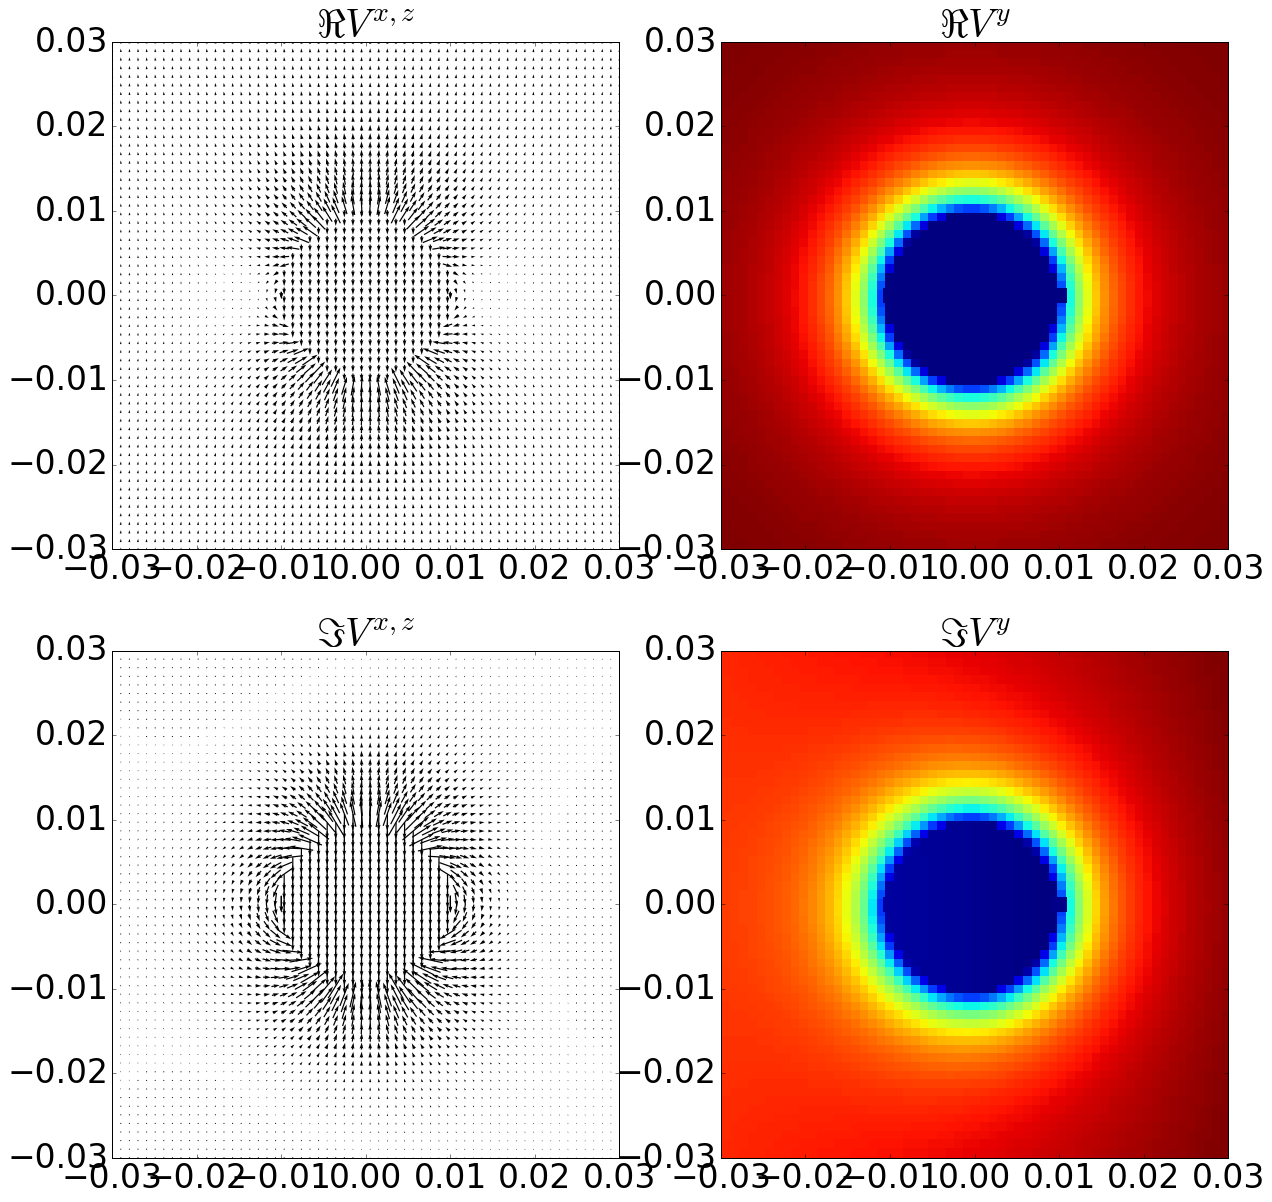

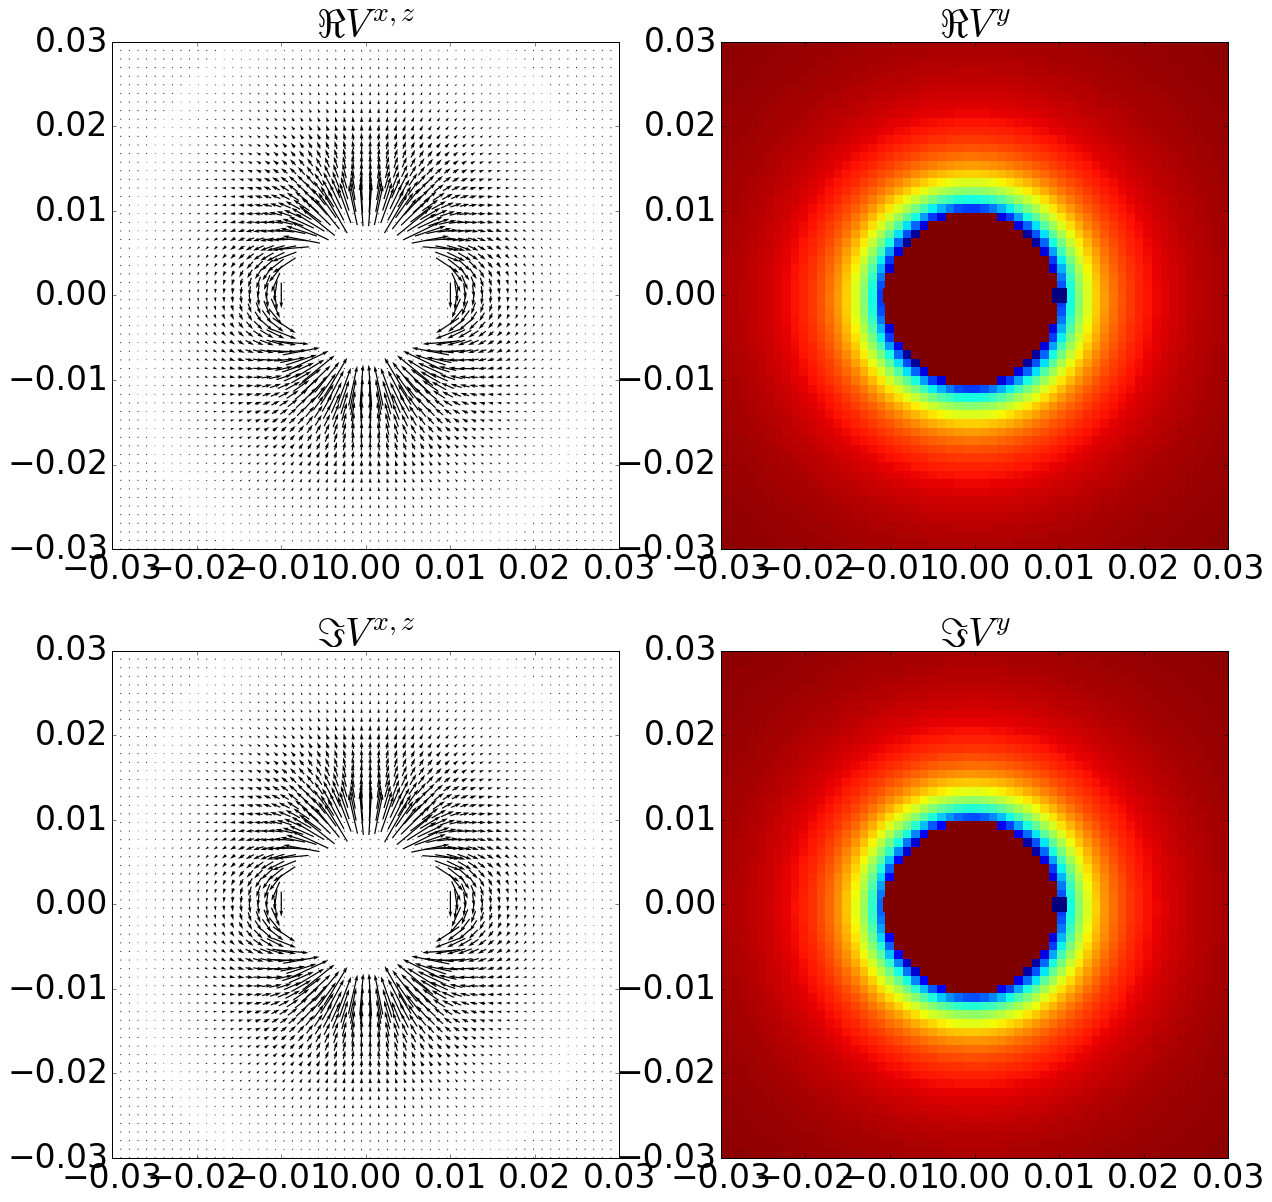

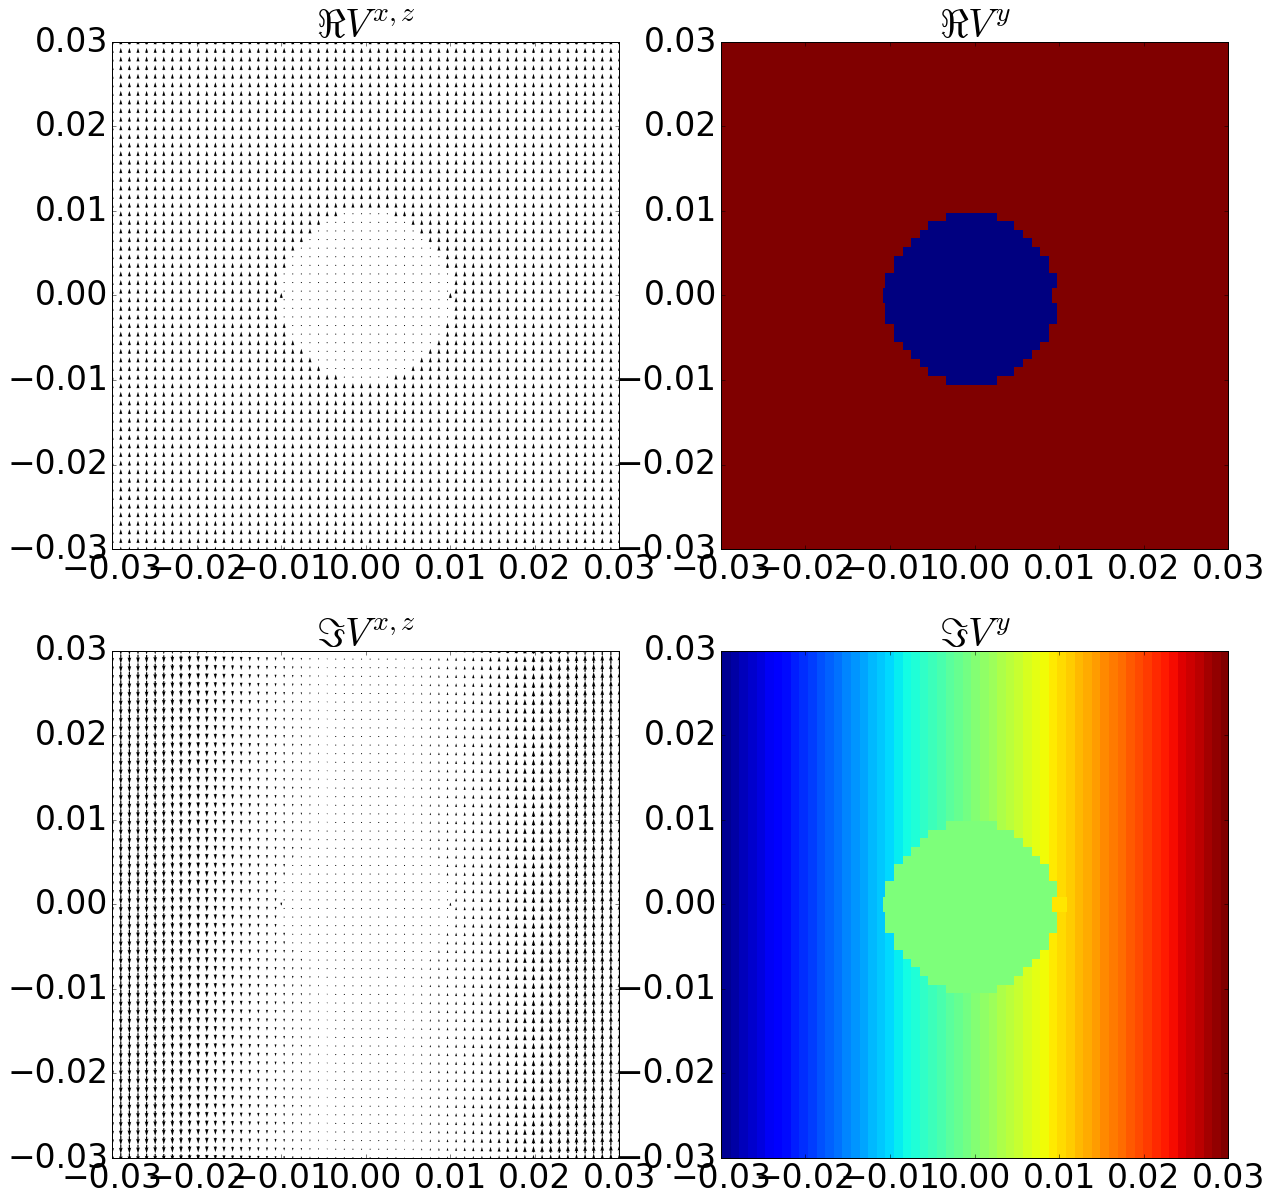

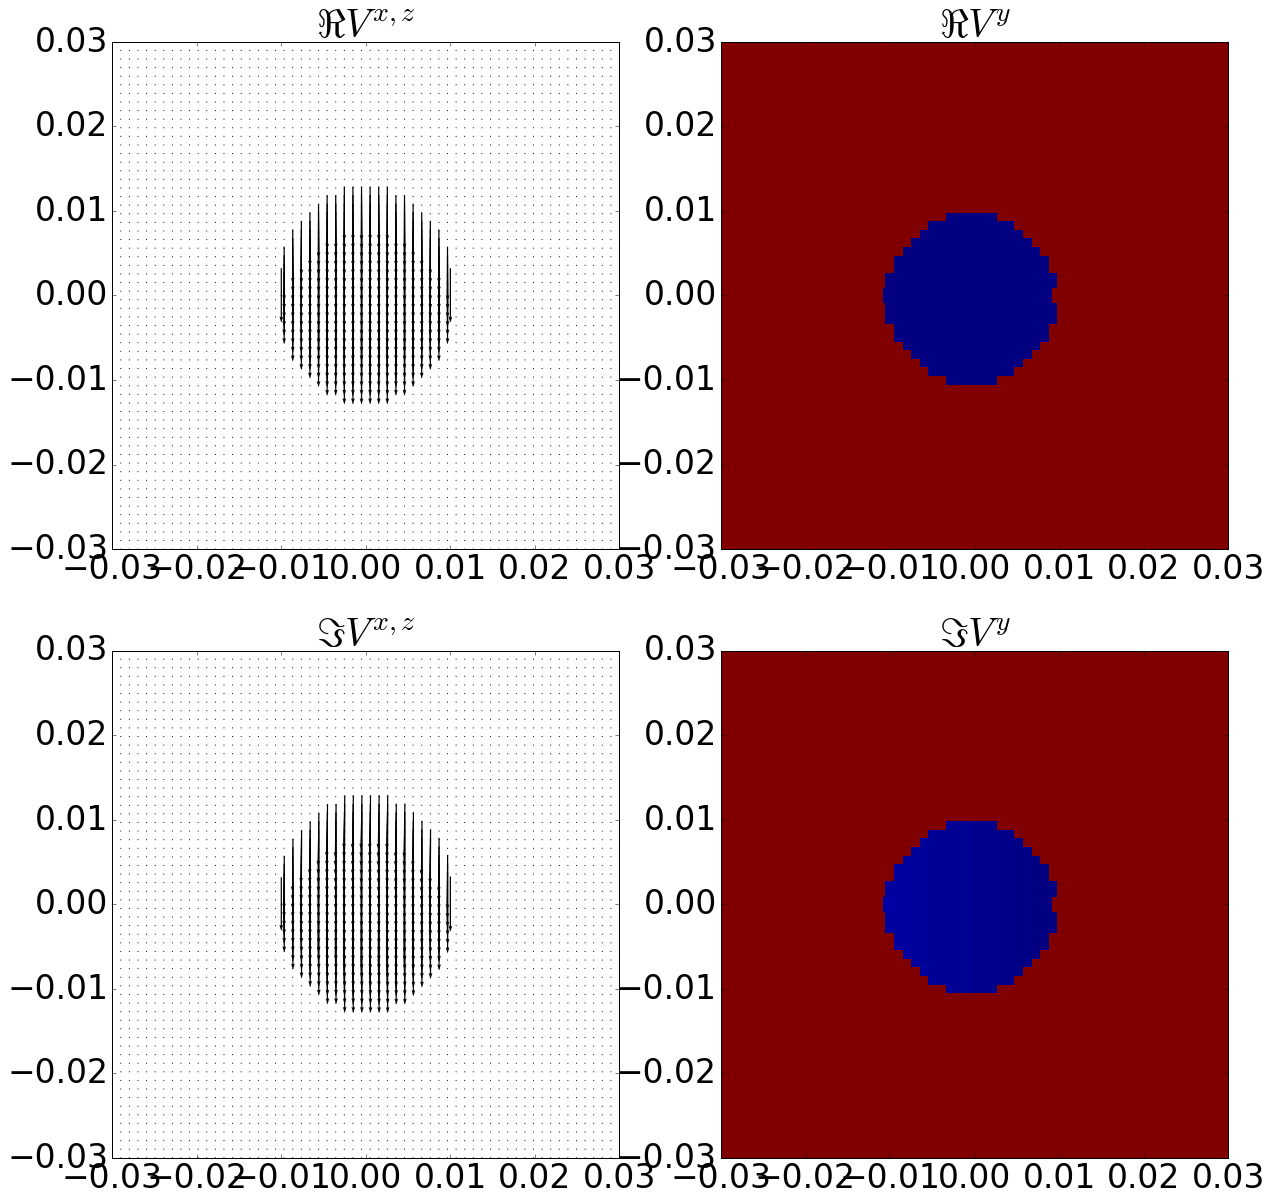

In [58]:
#import traceback
#import warnings
#import sys

#def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
#    traceback.print_stack()
#    log = file if hasattr(file,'write') else sys.stderr
#    log.write(warnings.formatwarning(message, category, filename, lineno, line))

#warnings.showwarning = warn_with_traceback

# Test Mieho rozptylu vs kvasistatické (dipólové) approximace malé koule
#import warnings
#warnings.filterwarnings('error')
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib



nmax = 20
J_ext = 1
J_scat = 3
#ω = 4*eV/ℏ 
ε_in  = -3.3024390243902424+0.24695121951219506j
ε_out = 1
μ_in = 1
μ_out = 1

R = .01
k_in = cmath.sqrt(ε_in*μ_in)#ω*math.sqrt(ε_in)/c
k_out = math.sqrt(ε_out*μ_out)#ω*cmath.sqrt(ε_out)/c
k_cart = k_out * np.array([1,0,0]) 
E⃗_0 = np.array([0,1,1])

h2 = 3*R
w2 = 3*R
z = np.linspace(-h2,h2,60)
y = np.linspace(-w2,w2,60)
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.0

# Souřadnice a původní vlna
my, ny = get_mn_y(nmax)
nelem = len(my)
#x = x.flatten()
#y = y.flatten()
#z = z.flatten()
x = np.concatenate((x.flatten(),R*np.array([-1.0001,-0.9999,0.9999,1.0001])))
y = np.concatenate((y.flatten(),R*np.array([0,0,0,0])))
z = np.concatenate((z.flatten(),R*np.array([0,0,0,0])))
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]


p_y, q_y = plane_pq_y(nmax, k_cart, E⃗_0)



M_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)

for ri in range(len(x)):
    if (sphgrid[ri,0] < R):
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_in,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=1)
        M_sph_ry_in[ri] = M
        N_sph_ry_in[ri] = N
    else:
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_scat)
        M_sph_ry_scat[ri] = M
        N_sph_ry_scat[ri] = N
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_ext)
        M_sph_ry_ext[ri] = M
        N_sph_ry_ext[ri] = N
    
M_cart_ry_ext = sph_loccart2cart(M_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_ext = sph_loccart2cart(N_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_scat = sph_loccart2cart(M_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_scat = sph_loccart2cart(N_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_in = sph_loccart2cart(M_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_in = sph_loccart2cart(N_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)


RH, RV, TH, TV = mie_coefficients(R, nmax,  #ω, ε_in, ε_out, μ_i=1, μ_e=1, 
                                  k_i=k_in, k_e=k_out,μ_i = μ_in, μ_e = μ_out,
                                  J_ext=J_ext, J_scat=J_scat)
a_y = p_y * RV[ny]
b_y = q_y * RH[ny]
d_y = p_y * TV[ny]
c_y = q_y * RH[ny]


E_int =  -1j*np.sum(+ d_y[ň,:,ň] * N_cart_ry_in  + c_y[ň,:,ň] * M_cart_ry_in, axis = -2)
E_scat=  +1j*np.sum(+ a_y[ň,:,ň] * N_cart_ry_scat+ b_y[ň,:,ň] * M_cart_ry_scat, axis = -2)
E_ext =  -1j*np.sum(+ p_y[ň,:,ň] * N_cart_ry_ext + q_y[ň,:,ň] * M_cart_ry_ext, axis = -2)
E_tot = E_int+E_scat+E_ext
#print(E_tot)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-19
plthr_hi = 10
Ep = [E_tot,E_scat,E_ext,E_int]
for page in [0,1,2,3]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    print(cartgrid)
    print(plotfield)
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(20,20))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=220,
                       edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=220,
                       edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()
print(Ep[2])
print((Ep[3])[32*15])
print("E_tot",E_tot[[-1,-2,-3,-4]])
print("E_int",E_int[[-1,-2,-3,-4]])
print("E_scat",E_scat[[-1,-2,-3,-4]])
print("E_ext",E_ext[[-1,-2,-3,-4]])

In [16]:
%debug
#import warnings
#warnings.filterwarnings('error')

### Test mie scattering of plane wave; the coefficients might still be wrong, 
### as this still does not give an almost exact equality of the nonradial fields at both sides of the boundary!!!!!!!!!!
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 3
betap = 2

J_ext=1
J_scat=3


R = 40e-9
ω = 4*eV/ℏ 
ε_in  = -3.3024390243902424+0.24695121951219506j
ε_out = 1


k_in = ω*cmath.sqrt(ε_in)/c
k_out = ω*cmath.sqrt(ε_out)/c
print("k_in:", k_in, ", k_out:", k_out)


z = np.linspace(-6,6,25)*1e-8
y = [0]
x = np.concatenate((np.linspace(-1.3,-0.05,12),np.linspace(0.05,1.3,12),
                   #np.array([-1.001,-0.999,0.999,1.001])
                   ))*R

my, ny = get_mn_y(nmax)
nelem = len(my)


x,y,z = np.meshgrid(x,y,z)
x = np.concatenate((x.flatten(),R*np.array([-1.0001,-0.9999,0.9999,1.0001])))
y = np.concatenate((y.flatten(),R*np.array([0,0,0,0])))
z = np.concatenate((z.flatten(),R*np.array([0,0,0,0])))
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

M_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)

for ri in range(len(x)):
    if (sphgrid[ri,0] < R):
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_in,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=1)
        M_sph_ry_in[ri] = M
        N_sph_ry_in[ri] = N
    else:
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_scat)
        M_sph_ry_scat[ri] = M
        N_sph_ry_scat[ri] = N
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_ext)
        M_sph_ry_ext[ri] = M
        N_sph_ry_ext[ri] = N
    
M_cart_ry_ext = sph_loccart2cart(M_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_ext = sph_loccart2cart(N_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_scat = sph_loccart2cart(M_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_scat = sph_loccart2cart(N_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_in = sph_loccart2cart(M_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_in = sph_loccart2cart(N_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)

RH, RV, TH, TV = mie_coefficients(R, nmax,  ω, ε_in, ε_out, μ_i=1, μ_e=1, J_ext=J_ext, J_scat=J_scat)

#p_y, q_y = zplane_pq_y(nmax,betap)
p_y = np.zeros(nelem)
q_y = np.zeros(nelem)
p_y[3] = 1
a_y = p_y * RV[ny]
b_y = q_y * RH[ny]
d_y = p_y * TV[ny]
c_y = q_y * RH[ny]

E_inc = np.sum(p_y[ň,:,ň] * N_cart_ry_ext + q_y[ň,:,ň] * M_cart_ry_ext
             + (a_y[ň,:,ň] * N_cart_ry_scat+ b_y[ň,:,ň] * M_cart_ry_scat) # snad je tu plus správně (minus dává větší rozdíly)
             + d_y[ň,:,ň] * N_cart_ry_in  + c_y[ň,:,ň] * M_cart_ry_in, axis = -2)
E_int =  np.sum(+ d_y[ň,:,ň] * N_cart_ry_in  + c_y[ň,:,ň] * M_cart_ry_in, axis = -2)
E_scat=  np.sum(+ a_y[ň,:,ň] * N_cart_ry_scat+ b_y[ň,:,ň] * M_cart_ry_scat, axis = -2)
E_ext =  np.sum(+ p_y[ň,:,ň] * N_cart_ry_ext + q_y[ň,:,ň] * M_cart_ry_ext, axis = -2)

print(E_inc[[-1,-2,-3,-4]])
print(E_int[[-1,-2,-3,-4]])
print(E_scat[[-1,-2,-3,-4]])
print(E_ext[[-1,-2,-3,-4]])

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 10
Ep = [E_inc,E_int,E_ext,E_scat]
for page in [0,1,2,3]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(20,20))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()


> <ipython-input-7-b402eeceefc3>(46)mie_coefficients()
     45     # We "need" the absolute permeabilities for the final formula
---> 46     μ_i = μ_i * μ_0
     47     μ_e = μ_e * μ_0

ipdb> q
k_in: (1376367.435834251+36863271.20271336j) , k_out: (20270923.76600504+0j)


TypeError: mie_coefficients() got an unexpected keyword argument 'μ_i'

In [6]:
### The vector functions' spherical products (in order to evaluate the expansion coefficients numerically)
nmax = 6
theta_res = 50
fi_res = 100
R = np.array([1])
theta = np.linspace(π/theta_res, π, theta_res, endpoint=False)
fi = np.linspace(0, 2*π, fi_res,endpoint = False)


sph = np.meshgrid(R, theta, fi)
sph = [sph[i].flatten() for i in range(3)]
weight = np.sin(sph[1])*4*π*R*R/(theta_res*fi_res)
sph = np.stack(sph, axis=-1)
cart = sph2cart(sph)


my, ny = get_mn_y(nmax)
nelem = len(my)
M_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
print(weight)
for ri in range(sph.shape[0]):
    M, N = vswf_yr1(sph[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sph[:,ň,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sph[:,ň,:], axis=-1)

betap = 0.1
E⃗_0 = np.array([math.cos(betap),math.sin(betap),0])
E_plane = E⃗_0[ň,:] * np.exp(1j*cart[:,2])[:,ň]

p_čitatel_y = np.sum(np.sum(E_plane[:,ň,:]*N_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
q_čitatel_y = np.sum(np.sum(E_plane[:,ň,:]*M_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
p_norma_y = np.sum(np.sum(N_cart_ry.conj()*N_cart_ry, axis=-1)*weight[:,ň],axis=0)
q_norma_y = np.sum(np.sum(M_cart_ry.conj()*M_cart_ry, axis=-1)*weight[:,ň],axis=0)
pnum_y = 1j * p_čitatel_y / p_norma_y
qnum_y = 1j * q_čitatel_y / q_norma_y

pp_y, qq_y = zplane_pq_y(nmax,betap)
for y in range(len(my)):
    print("m = "+str(my[y])+", n = "+str(ny[y])+", p_y = "+str(pnum_y[y])+", q_y = "+str(qnum_y[y])+" (num)")
    print("m = "+str(my[y])+", n = "+str(ny[y])+", p_y = "+str(pp_y[y])+", q_y = "+str(qq_y[y])+" (anal)")
    

[ 0.00015781  0.00015781  0.00015781 ...,  0.00015466  0.00015466
  0.00015466]
m = -1, n = 1, p_y = (-0.216700245161+2.16018668386j), q_y = (0.216701049615-2.15901189729j) (num)
m = -1, n = 1, p_y = (-0.216718756597+2.15995878686j), q_y = (0.216718756597-2.15995878686j) (anal)
m = 0, n = 1, p_y = (-2.34312230811e-18-2.76303793493e-18j), q_y = (4.58557555628e-17+1.5780544359e-16j) (num)
m = 0, n = 1, p_y = 0j, q_y = 0j (anal)
m = 1, n = 1, p_y = (-0.216782175183-2.16017846344j), q_y = (-0.216547992703-2.15902725421j) (num)
m = 1, n = 1, p_y = (-0.216718756597-2.15995878686j), q_y = (-0.216718756597-2.15995878686j) (anal)
m = -2, n = 2, p_y = (-4.08892334037e-17+1.76828998309e-16j), q_y = (9.77537267556e-17-1.96181568463e-16j) (num)
m = -2, n = 2, p_y = (-0+0j), q_y = (-0+0j) (anal)
m = -1, n = 2, p_y = (-1.60923107933-0.161518104486j), q_y = (1.61596107834+0.162572659474j) (num)
m = -1, n = 2, p_y = (-1.60993822534-0.161532623917j), q_y = (1.60993822534+0.161532623917j) (anal)
m = 0, n

-1 1 A1 (-1.48835912175e-07+0j) B1 0j AJ (-1.48835912175e-07+0j) BJ 0j
0 1 A1 (-0.000210485695408+0j) B1 0.000461809001826j AJ (-0.000210485695408+0j) BJ 0.000461809001826j
1 1 A1 (0.35542488772+0j) B1 0.653096335922j AJ (0.35542488772+0j) BJ 0.653096335922j
-2 2 A1 (3.39446675534e-11+0j) B1 0j AJ (3.39446675534e-11+0j) BJ 0j
-1 2 A1 (6.78893124783e-08-0j) B1 -1.10935739039e-07j AJ (6.78893124783e-08-0j) BJ -1.10935739039e-07j
0 2 A1 (-5.27209405234e-05+0j) B1 (-0-0.000271735864311j) AJ (-5.27209405234e-05+0j) BJ (-0-0.000271735864311j)
1 2 A1 (-0.26491789444+0j) B1 -0.221871219236j AJ (-0.26491789444+0j) BJ -0.221871219236j
2 2 A1 (0.000264917948797+0j) B1 0.000221871404125j AJ (0.000264917948797+0j) BJ 0.000221871404125j
-3 3 A1 (-6.37592652655e-15+0j) B1 0j AJ (-6.37592652655e-15+0j) BJ 0j
-2 3 A1 (-1.56177614219e-11+0j) B1 2.24522871707e-11j AJ (-1.56177614219e-11+0j) BJ 2.24522871707e-11j
-1 3 A1 (5.35256809652e-09+0j) B1 7.10003424743e-08j AJ (5.35256809652e-09+0j) BJ 7.100034247

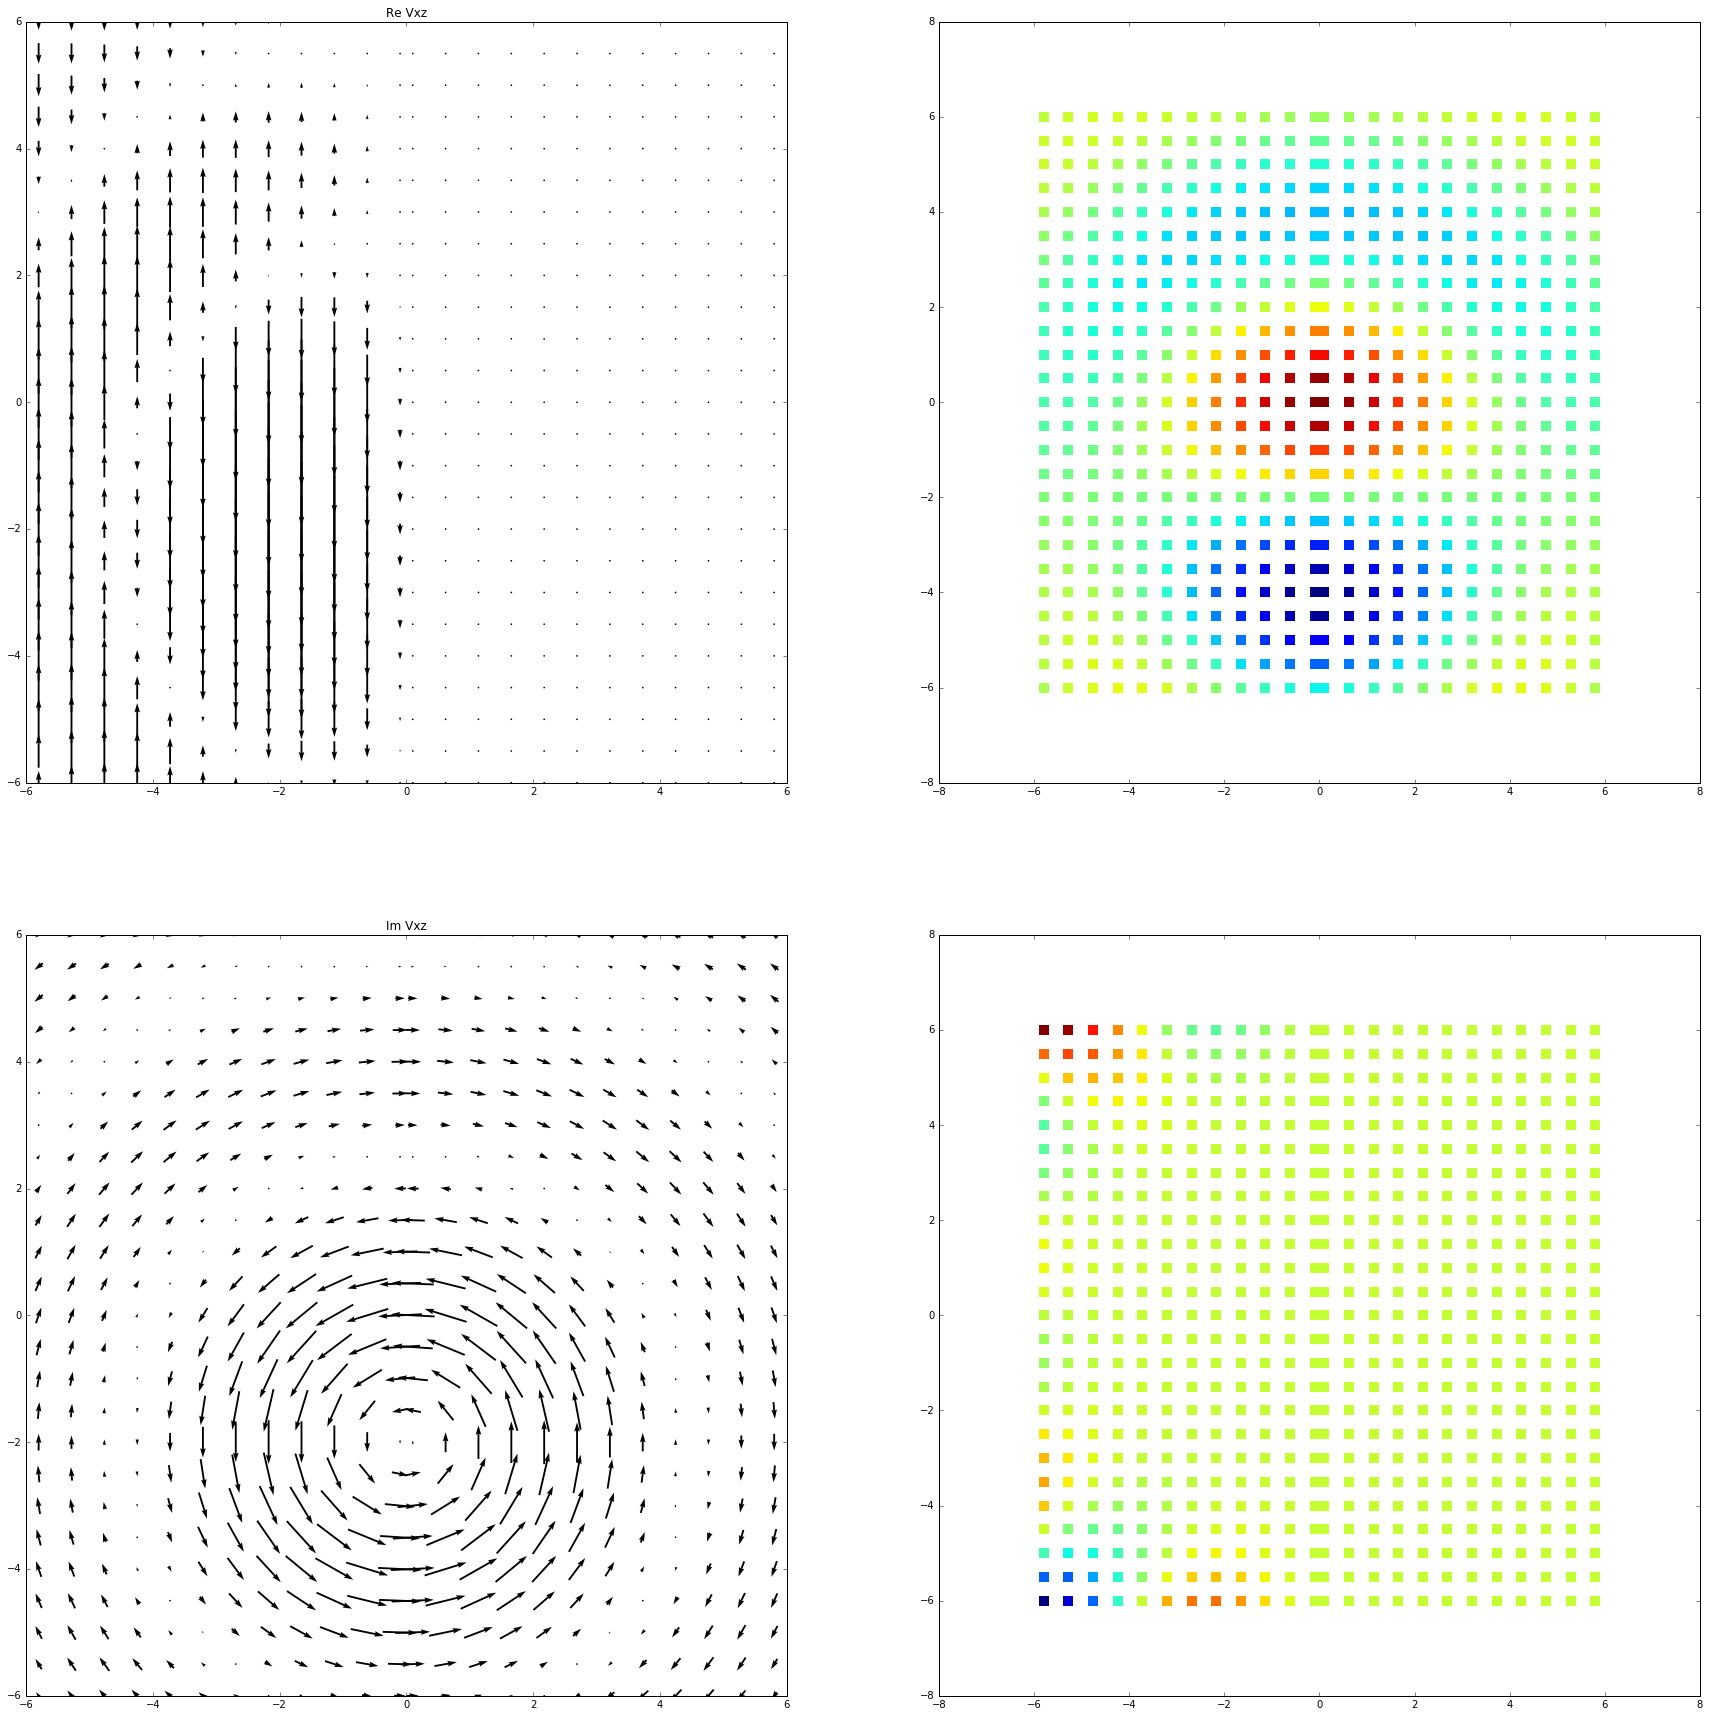

In [7]:
# Test posunů kulových vln
#%debug
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 8
z = np.linspace(-6,6,25)
y = [0]
x = np.concatenate((np.linspace(-5.8,-0.1,12),np.linspace(0.1,5.8,12)))

my, ny = get_mn_y(nmax)
nelem = len(my)
x,y,z = np.meshgrid(x,y,z)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

μ = 1
ν = 1
J = 1 # začnem zlehka

shift_r = 2
shift_θ = 0.001
shift_φ = 0.0 # říkám zlehka

Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)

for y in range(nelem):
    Ã1_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    B̃1_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    ÃJ_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J)
    B̃J_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J)
    print(my[y],ny[y],"A1",Ã1_y[y],"B1",B̃1_y[y],"AJ",ÃJ_y[y],"BJ",B̃J_y[y])
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=J)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
    # TODO check r < d
    
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
# This will not work for J != 1
Mμν = np.sum(Ã1_y[ň,:,ň] * M_cart_ry[:,:,:] + B̃1_y[ň,:,ň] * N_cart_ry[:,:,:], axis=-2)

plotfield = Mμν[:,:]
#plotfield = M_cart_ry[:,2,:]

print(my[7],ny[7])

f, axarr = plt.subplots(2, 2, figsize=(30,30))
hor_axis = 0
perp_axis = 1
ver_axis = 2
print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
      "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
      "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
      "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
      "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
axarr[0,0].set_title("Re Vxz")
axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].real,marker='s')
#axarr[0,1].xlim[np.min(x),np.max(x)]
#axarr[0,1].ylim[np.min(z),np.max(z)]
axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
axarr[1,0].set_title("Im Vxz")
axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].imag,marker='s')


#plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))

#print(Ã1_y,B̃1_y)

In [ ]:
B̃(-1,1,1,1,2.0,0.5,0.0,False,3)

In [ ]:
get_π̃τ̃_y1(0.001,4)

(992, 3)
max|Re Vx| =

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:116: RuntimeWarning: invalid value encountered in true_divide
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))


 0.134480993563 ; max|Re Vy| = 0.0134480993563 ; max|Re Vz| = 0.271920596556
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.0
(0.134480993563+0j) (0.0134480993563+0j) (0.271920596556+0j)
max|Re Vx| = 0.134480993563 ; max|Re Vy| = 0.0134480993563 ; max|Re Vz| = 0.271920596556
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.0
(0.134480993563+0j) (0.0134480993563+0j) (0.271920596556+0j)
max|Re Vx| = 0.0 ; max|Re Vy| = 0.0 ; max|Re Vz| = 0.0
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.0
0j

/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:701: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:711: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in less


 (-0+0j) 0j
max|Re Vx| = nan ; max|Re Vy| = nan ; max|Re Vz| = 1.00000000001
max|Im Vx| = nan ; max|Im Vy| = nan ; max|Im Vz| = 0.0
(nan+nan*j) (nan+nan*j) (1.00000000001+0j)
[[ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]
 ..., 
 [ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]]
[ -0. +0.j  nan+nanj   1. +0.j]


/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in less
/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in greater
/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in greater


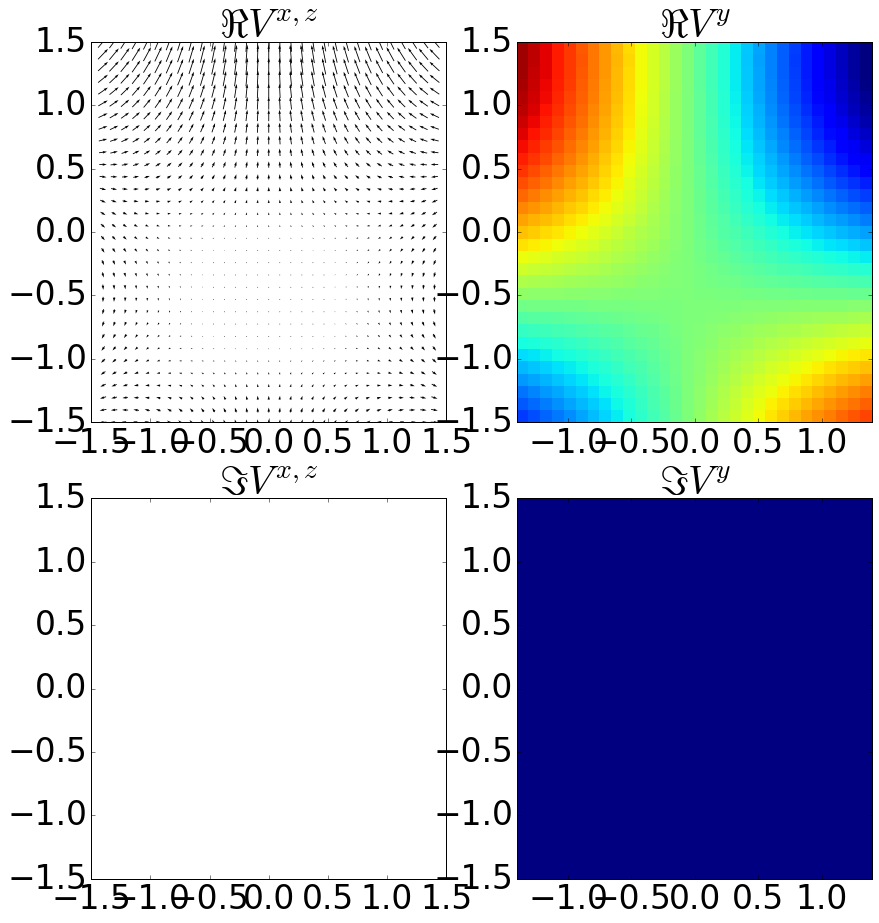

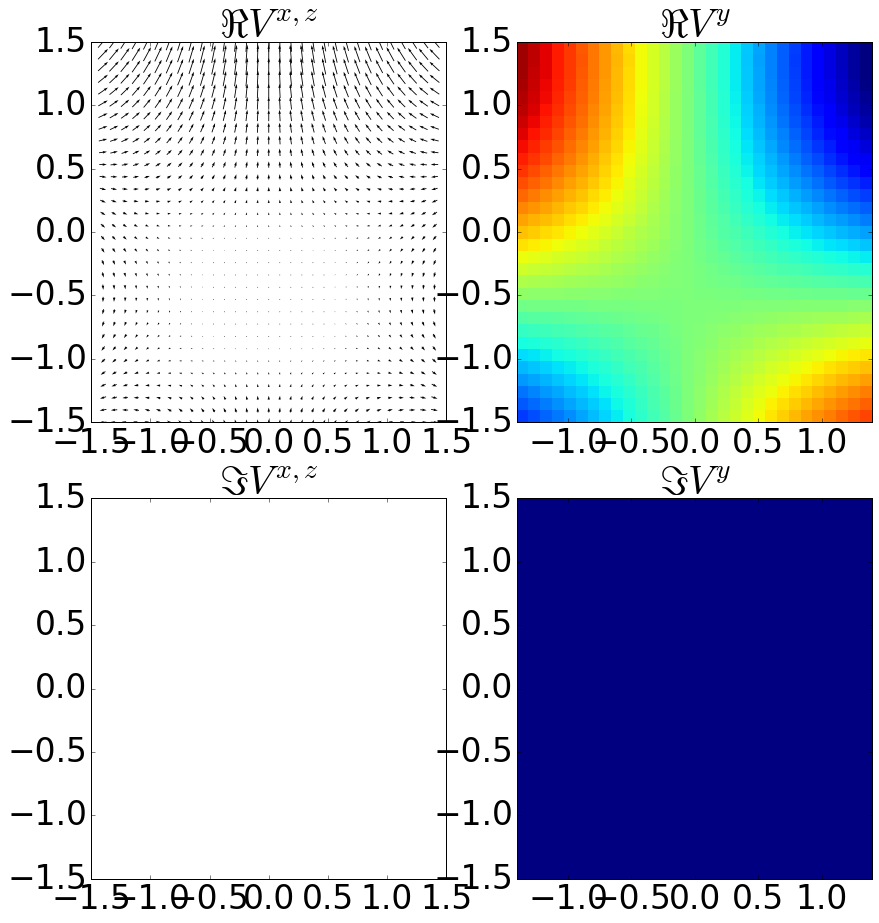

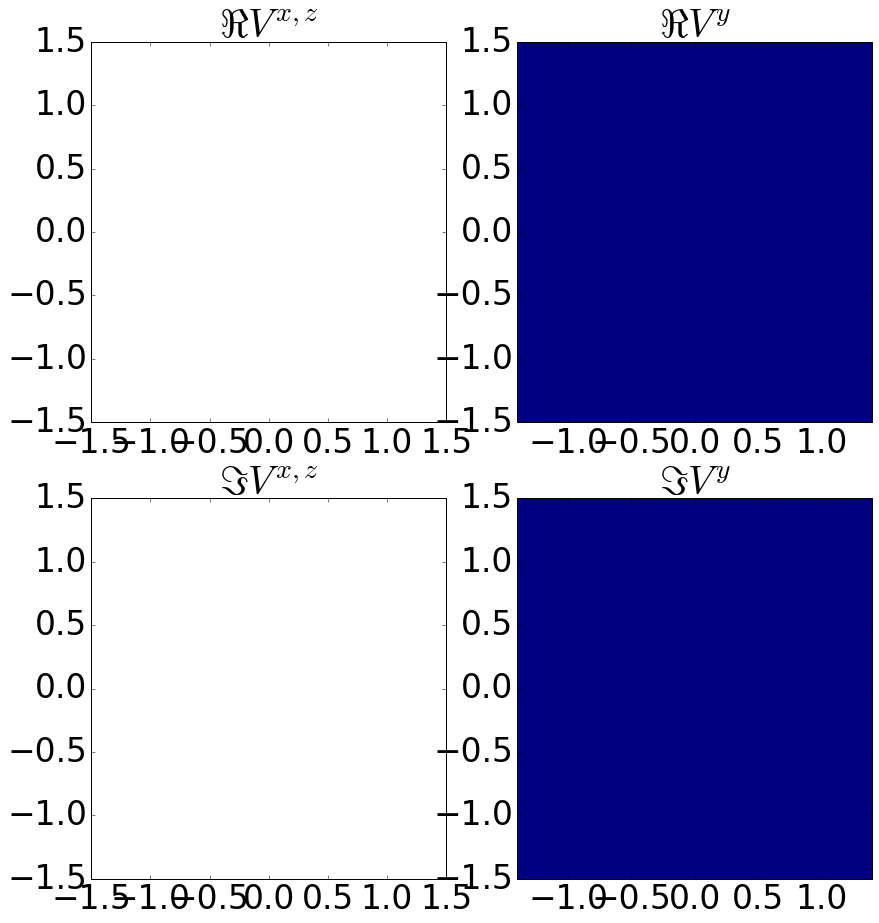

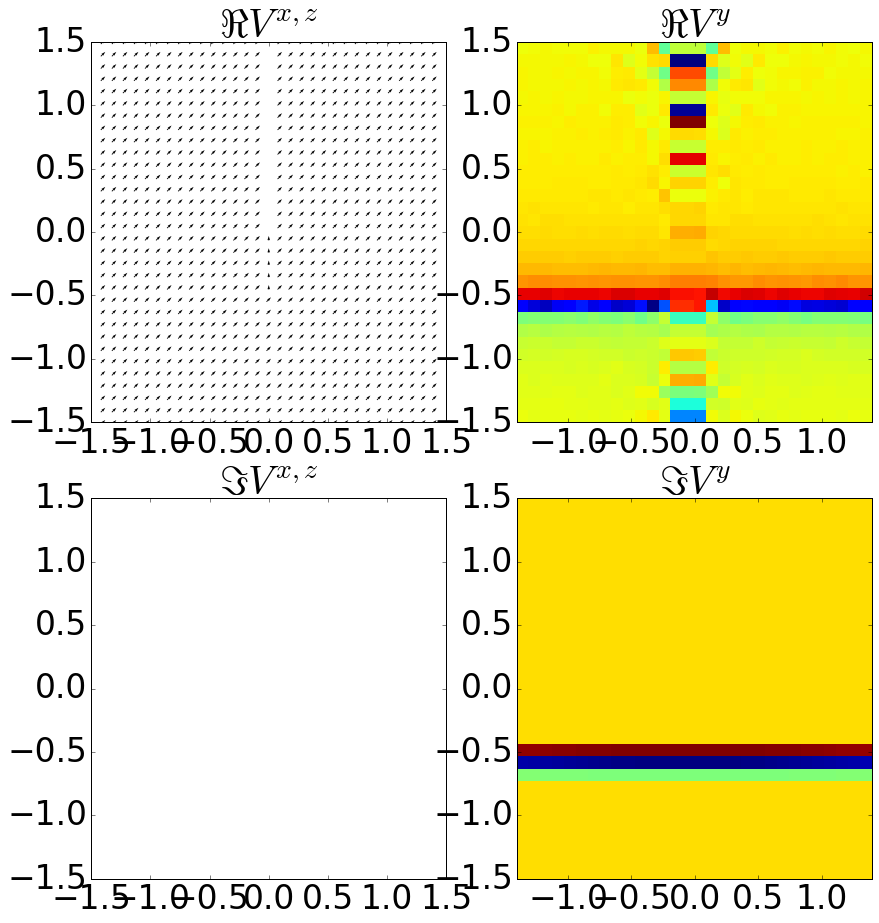

In [8]:
# Test posunutých vln
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

nmax = 20

# dotyčná vlna
N_not_M = 1 # 0 je M
μ = 0
ν = 3
J_orig = 1 # typ původní přesouvané vlny
J = 1      # doplňující typ (vždy 1, vyjma nestandardního rozkladu typu 3-4 (nyní neimplementováno))

# Posun _současného počátku_ vůči zdroji (tj. na obrázku bude poloha zdroje mínus toto)
shift_r = 0.5
shift_θ = 0.0
shift_φ = 0.0 # říkám zlehka
my, ny = get_mn_y(nmax)
nelem = len(my)
source_y = (np.arange(nelem)[(my==μ)*(ny==ν)])[0]
shift_cart = sph2cart(np.array([shift_r,shift_θ,shift_φ]))




h2 = 1.5
w2 = 1.4
z = np.linspace(-h2,h2,32)
y = np.linspace(-w2,w2,31)
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.1

# Souřadnice a původní vlna
nelem = nmax * (nmax + 2)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
cartgrid_shifted = cartgrid + shift_cart[ň,:]
sphgrid = cart2sph(cartgrid)
sphgrid_shifted = cart2sph(cartgrid_shifted)
r_le_d = (sphgrid[:,0] <= shift_r)

#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
# --- the basis waves
M_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_out = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_out = np.zeros((len(x),nelem,3),dtype=np.complex_)

for ri in range(len(x)):
    if (r_le_d[ri]):
        # TODO musí se řešit jinak, pokud J != 1
        M, N = vswf_yr1(sphgrid[ri],nmax,J=J)
        M_sph_ry_in[ri] = M
        N_sph_ry_in[ri] = N
    else:
        M, N = vswf_yr1(sphgrid[ri],nmax,J=J_orig)
        M_sph_ry_out[ri] = M
        N_sph_ry_out[ri] = N

M_cart_ry_in = sph_loccart2cart(M_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_in = sph_loccart2cart(N_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_out = sph_loccart2cart(M_sph_ry_out, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_out = sph_loccart2cart(N_sph_ry_out, sphgrid[:,np.newaxis,:], axis=-1)

# --- the "original" wave (computed directly by shifting, not by resummation)
M_shift_sph_ry = np.zeros((sphgrid.shape[0],nelem,3),dtype=np.complex_)
N_shift_sph_ry = np.zeros((sphgrid.shape[0],nelem,3),dtype=np.complex_)
#V_orig_sph = np.zeros((sph.shape[0],3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid_shifted[ri],nmax,J=J_orig)
    M_shift_sph_ry[ri] = M
    N_shift_sph_ry[ri] = N
M_shift_cart_ry = sph_loccart2cart(M_shift_sph_ry, sphgrid_shifted[:,ň,:], axis=-1)
N_shift_cart_ry = sph_loccart2cart(N_shift_sph_ry, sphgrid_shifted[:,ň,:], axis=-1)
E_orig = (N_shift_cart_ry if N_not_M else M_shift_cart_ry)[:,source_y,:]
print(E_orig.shape)



# Rozložená vlna
Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)
for y in range(nelem):
    Ã1_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    B̃1_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    ÃJ_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J_orig)
    B̃J_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J_orig)

if N_not_M:
    q_y_in = B̃J_y
    p_y_in = ÃJ_y
    q_y_out = B̃1_y
    p_y_out = Ã1_y
else:
    p_y_in = B̃J_y
    q_y_in = ÃJ_y
    p_y_out = B̃1_y
    q_y_out = Ã1_y
    
E_inc = np.sum(p_y_in[ň,:,ň] * N_cart_ry_in +  q_y_in[ň,:,ň] * M_cart_ry_in
             + p_y_out[ň,:,ň]* N_cart_ry_out+  q_y_out[ň,:,ň]* M_cart_ry_out, axis = -2)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 10
Ep = [E_inc,E_orig,E_inc-E_orig,E_orig/E_inc]
for page in [0,1,2,3]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()
print(Ep[3])
print((Ep[3])[32*15])

In [ ]:
# STARÉ TESTY ====================================================================================================================



# Kreslení odchozích vln
J=3
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
nmax = 4
h2 = 3
w2 = 2.9320
z = np.linspace(-3,3,32)
y = np.concatenate((np.linspace(-w2,-0.02*w2,15),np.linspace(0.02*w2,w2,15)))
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.2

nelem = nmax * (nmax + 2)
my, ny = get_mn_y(nmax)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
E⃗_0 = np.array([math.cos(betap),math.sin(betap),0])
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=J)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 1
for page in range(len(my)):
    plotfield = N_cart_ry[:,page,:]
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    f.suptitle("$N_{"+str(my[page])+"}^{"+str(ny[page])+"("+str(J)+")}$ (xz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()

max|Re Vx| = 0.0576387600619 ; max|Re Vy| = 0.577350228466 ; max|Re Vz| = 0.574465376056
max|Im Vx| = 0.057638795131 ; max|Im Vy| = 0.577350269153 ; max|Im Vz| = 0.574465026535
(0.0576387600619+0.000101808562489j) (0.57734743275+0.00180975983581j) (0.574465376056-0.000792477095215j)
max|Re Vx| = 0.0576387600619 ; max|Re Vy| = 0.577350228466 ; max|Re Vz| = 0.574465376056
max|Im Vx| = 0.057638795131 ; max|Im Vy| = 0.577350269153 ; max|Im Vz| = 0.574465026535
(0.0576387600619+0.000101808562489j) (0.57734743275+0.00180975983581j) (0.574465376056-0.000792477095215j)
max|Re Vx| = 0.0 ; max|Re Vy| = 1.11188835916e-13 ; max|Re Vz| = 0.0
max|Im Vx| = 2.07405273511e-13 ; max|Im Vy| = 6.21835916093e-13 ; max|Im Vz| = 1.74305014866e-13
(-0+0j) (1.11188835916e-13-6.13509243408e-13j) 1.74305014866e-13j
max|Re Vx| = 1.0 ; max|Re Vy| = 1.0 ; max|Re Vz| = 1.0
max|Im Vx| = 3.5988190756e-12 ; max|Im Vy| = 2.18741432302e-13 ; max|Im Vz| = 1.42928178444e-13
(1+0j) (1-2.18741432302e-13j) (1+0j)


/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:701: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:711: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


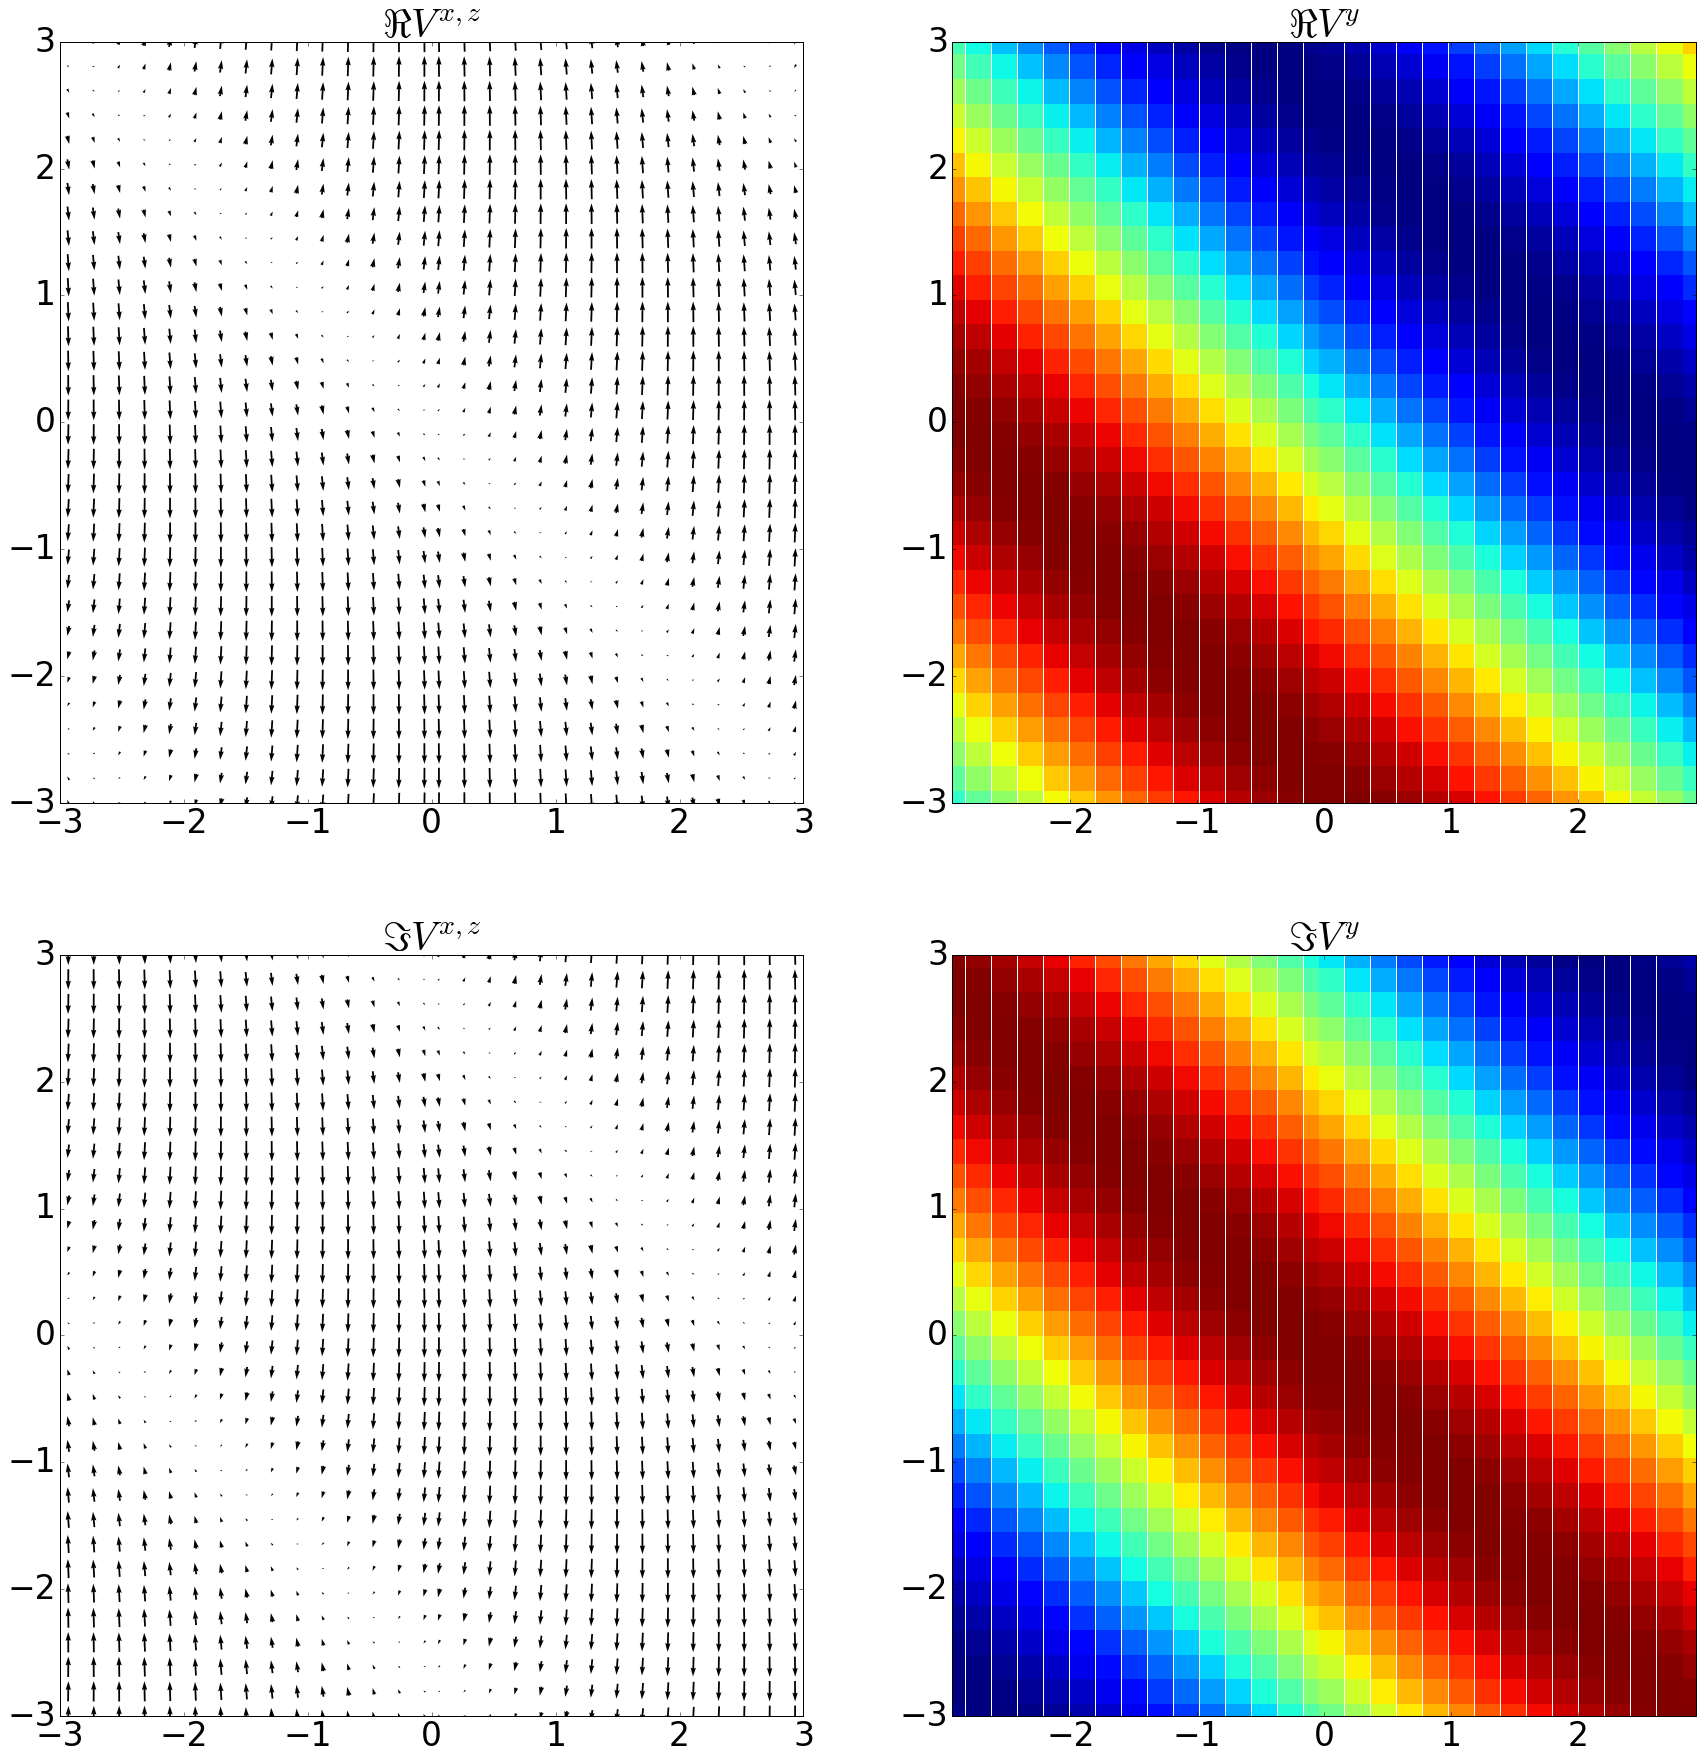

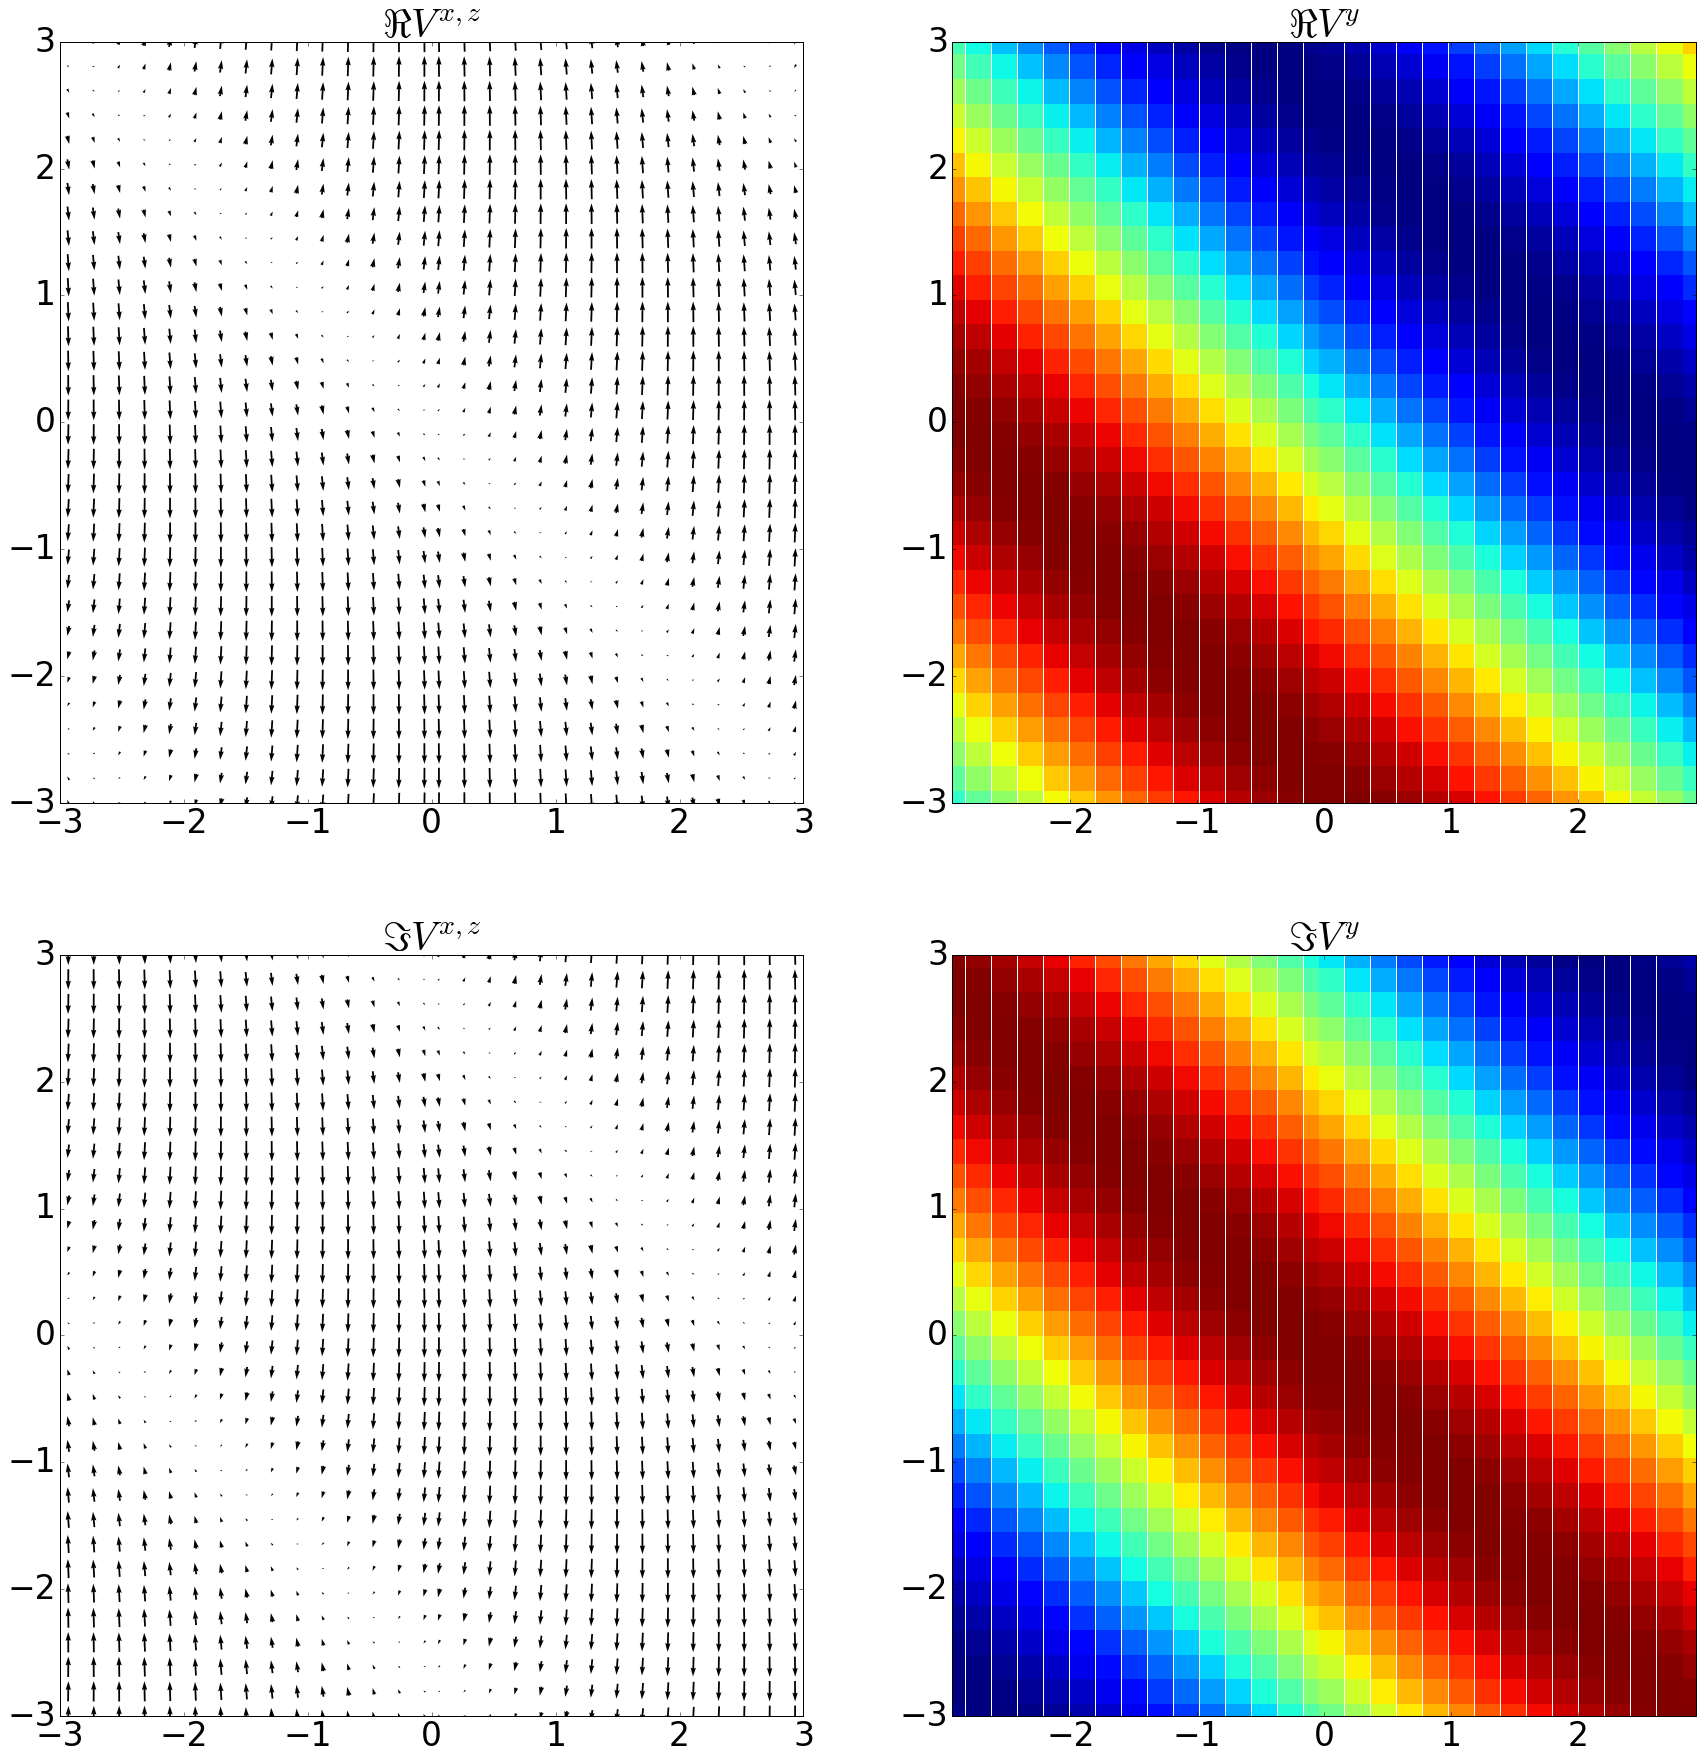

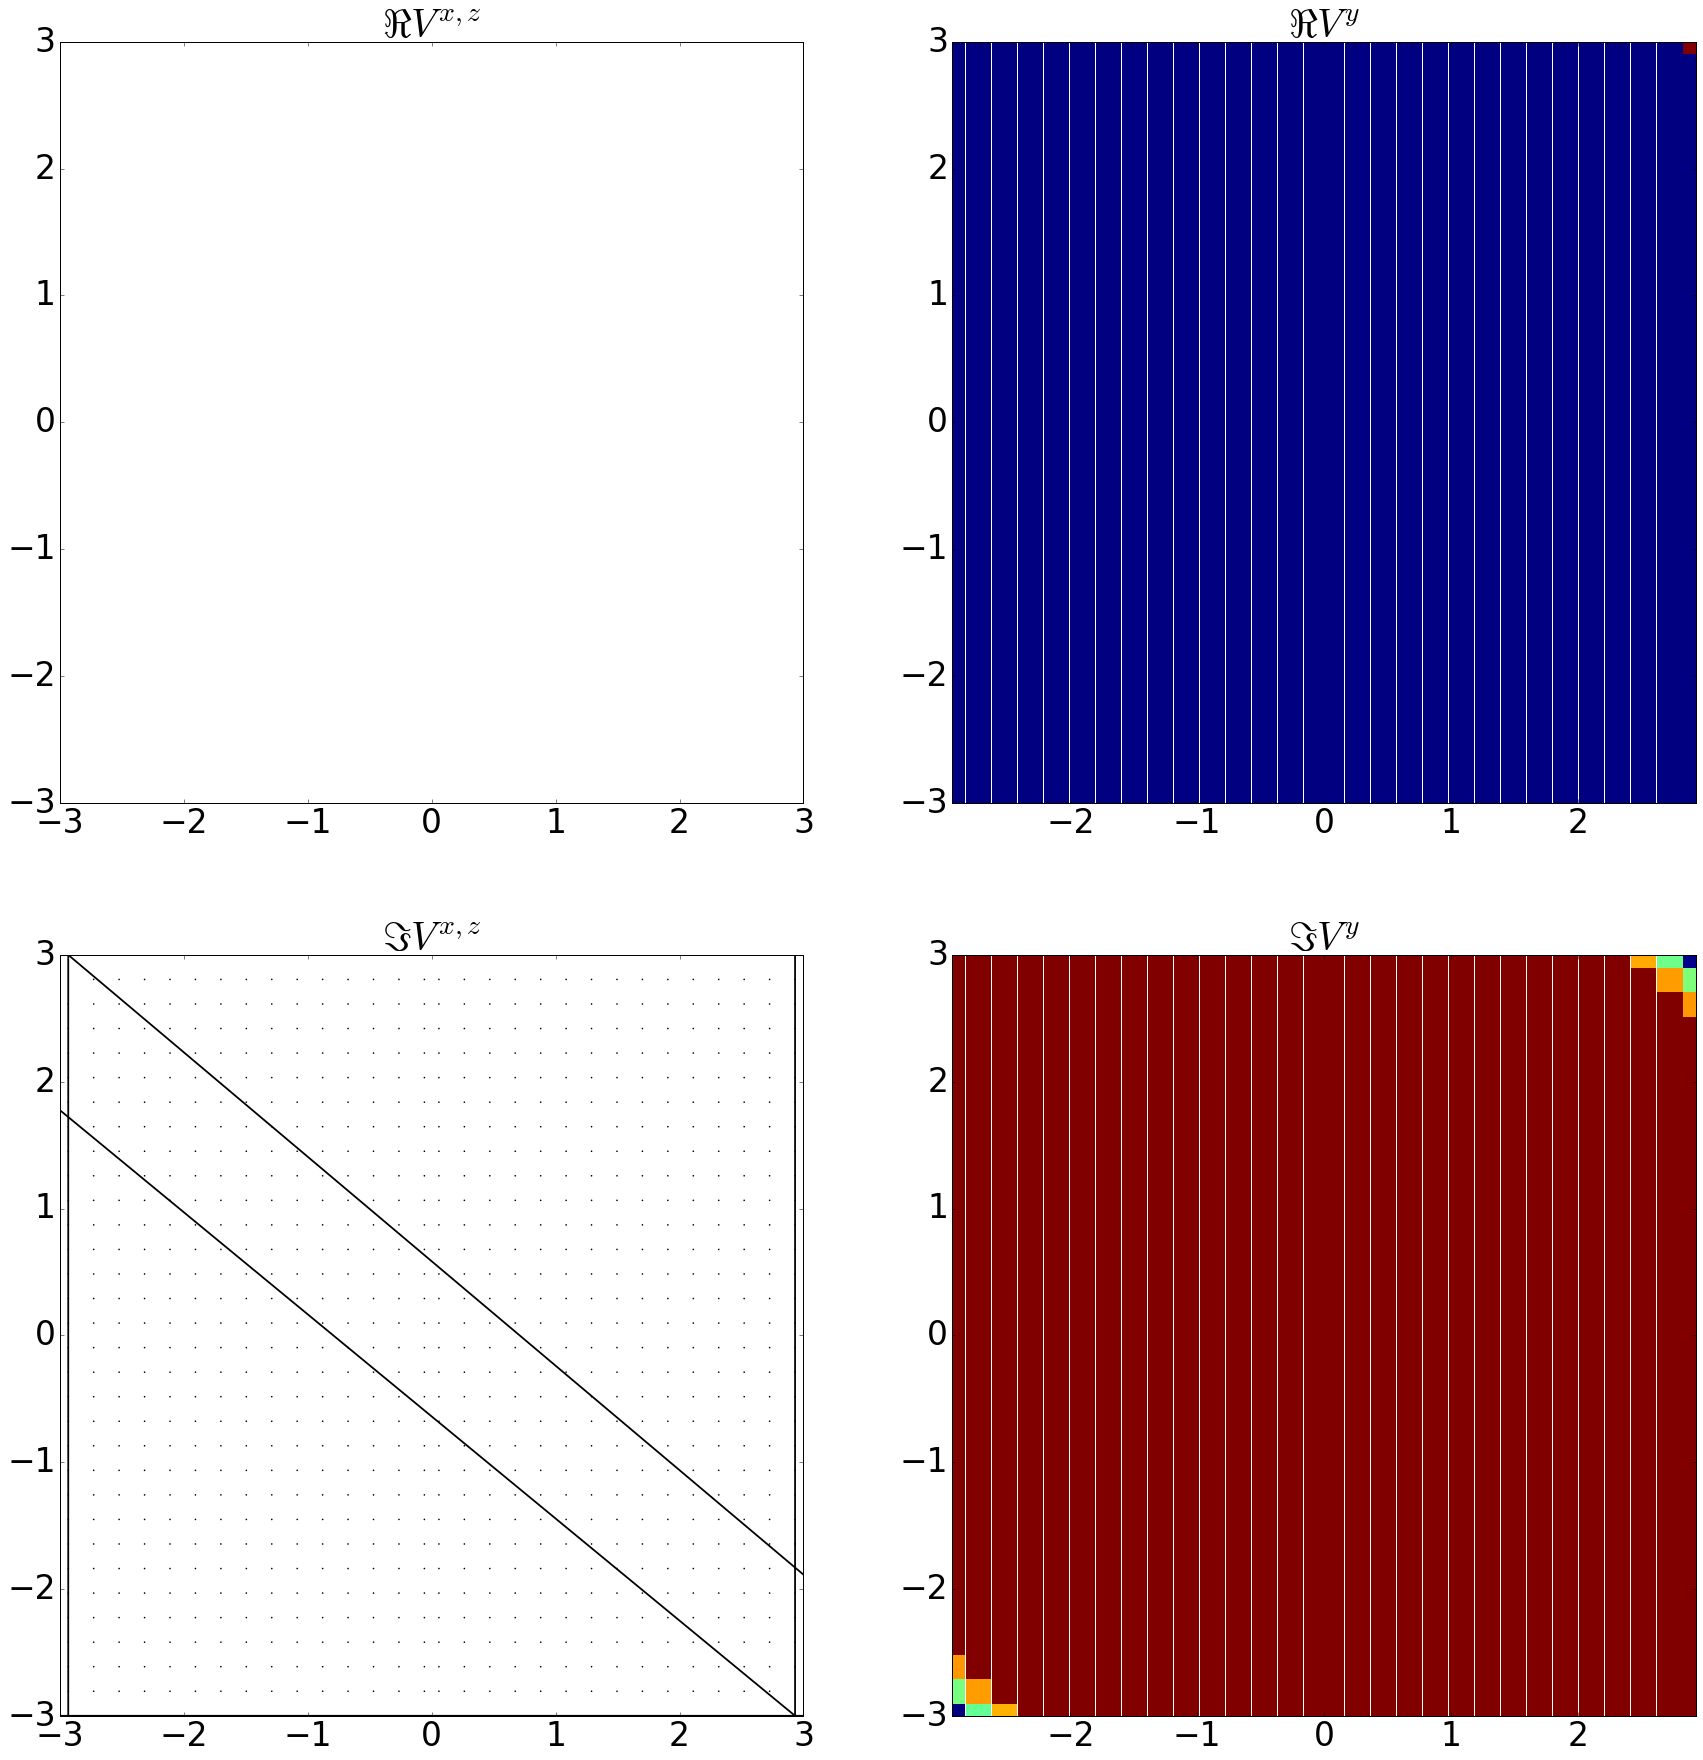

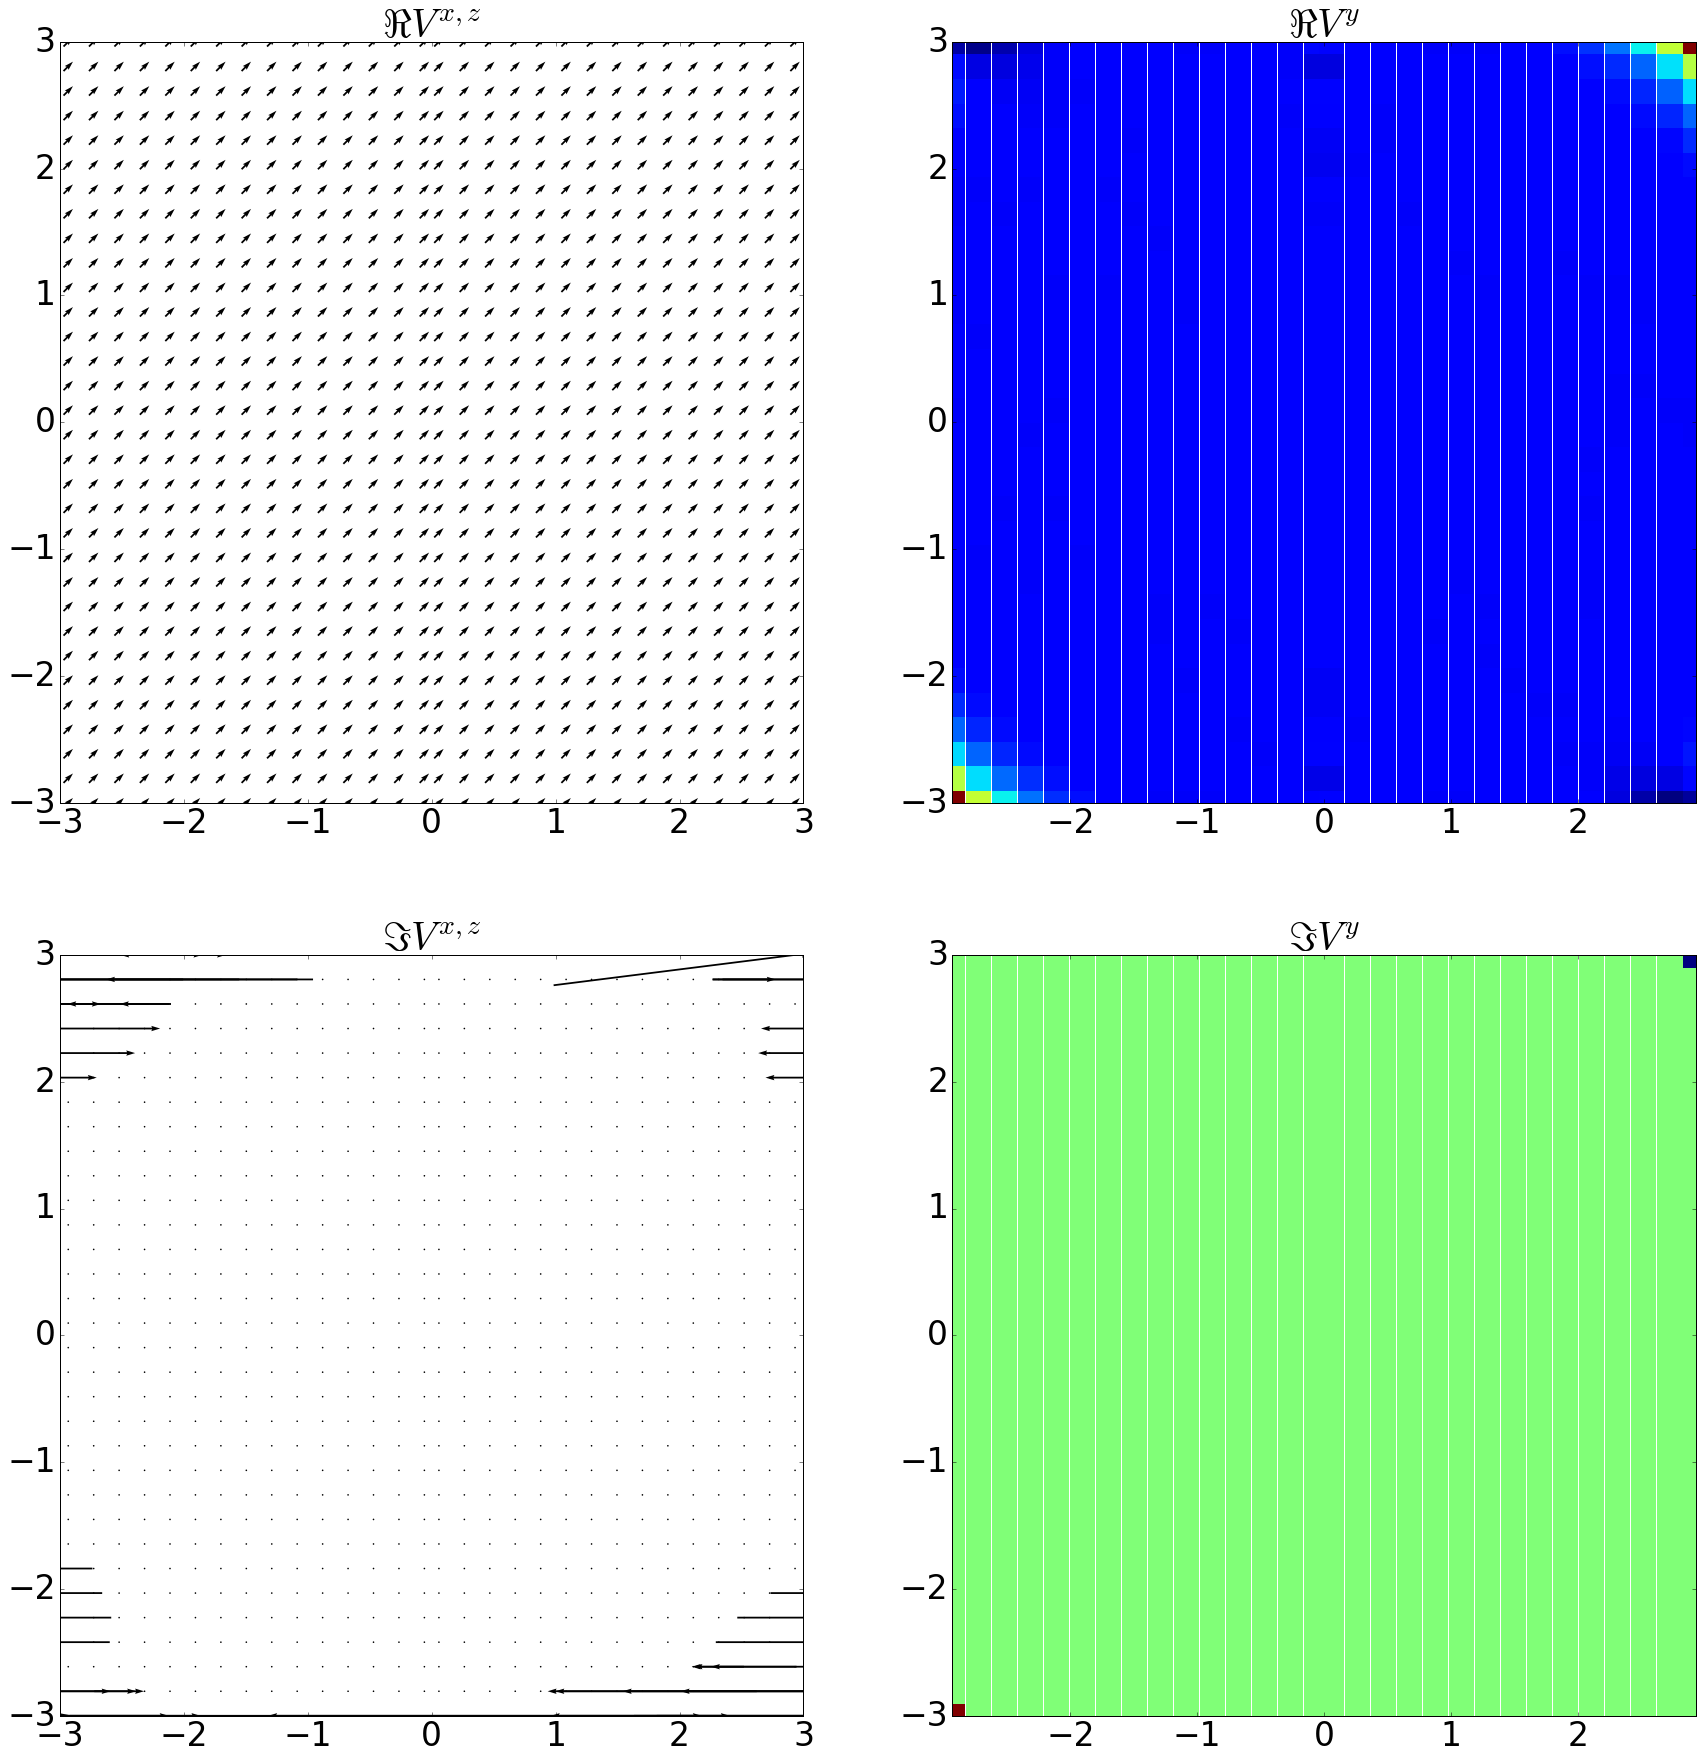

In [15]:
# Test rovinných vln 
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

nmax = 20
h2 = 3
w2 = 2.9320
z = np.linspace(-3,3,32)
y = np.concatenate((np.linspace(-w2,-0.02*w2,15),np.linspace(0.02*w2,w2,15)))
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.0

nelem = nmax * (nmax + 2)
my, ny = get_mn_y(nmax)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
betap = 0.1#π/2
k_cart = np.array([1,1,1])/math.sqrt(3)
E⃗_0 = np.cross(k_cart,np.array([1j*math.cos(betap),0,math.sin(betap)]))
E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)

#p_y, q_y = zplane_pq_y(nmax,betap)
#print (p_y,q_y)
p_y, q_y = plane_pq_y(nmax, k_cart, E⃗_0)
#print (p_y,q_y)
###
#p_y[(my == 1)] = 1j*p_y[(my == 1)].imag
#p_y[(my == -1)] = np.conj(p_y[(my == 1)])
#q_y[(my == 1)] = 1j*p_y[(my == 1)].real
#q_y[(my == -1)] = np.conj(p_y[(my == 1)])
#q_y[:] = 0
#p_y = p_y*(-1)**my
#q_y = q_y*(-1)**my
E_inc = -1j*np.sum(p_y[ň,:,ň] * N_cart_ry +  q_y[ň,:,ň] * M_cart_ry, axis = -2)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
for plotfield in [E_inc, E_plane, E_inc-E_plane, E_inc/E_plane]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]#-E_plane[:,:]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()

In [8]:
### Posuny kulových vln numericky
nmax = 15
theta_res = 30
fi_res = 100
R = np.array([1])
theta = np.linspace(π/theta_res, π, theta_res, endpoint=False)
fi = np.linspace(0, 2*π, fi_res,endpoint = False)


sph = np.meshgrid(R, theta, fi)
sph = [sph[i].flatten() for i in range(3)]
weight = np.sin(sph[1])*4*π*R*R/(theta_res*fi_res)
sph = np.stack(sph, axis=-1)
cart = sph2cart(sph)

my, ny = get_mn_y(nmax)
nelem = len(my)

# dotyčná vlna
μ = -1
ν = 3
J_orig = 1 # začnem zlehka
J = 1
source_y = (np.arange(nelem)[(my==μ)*(ny==ν)])[0]

# Posun _současného počátku_ vůči zdroji (tj. na obrázku bude poloha zdroje mínus toto)
shift_r = 0.7
shift_θ = 0.01
shift_φ = 0.0 # říkám zlehka
shift_cart = sph2cart(np.array([shift_r,shift_θ,shift_φ]))
# Zde plus, nebo mínus?
source_sph = cart2sph(cart+shift_cart)




M_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)

print(weight)
for ri in range(sph.shape[0]):
    M, N = vswf_yr1(sph[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sph[:,ň,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sph[:,ň,:], axis=-1)

M_shift_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
N_shift_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
#V_orig_sph = np.zeros((sph.shape[0],3),dtype=np.complex_)
for ri in range(sph.shape[0]):
    M, N = vswf_yr1(source_sph[ri],nmax,J=J_orig)
    M_shift_sph_ry[ri] = M
    N_shift_sph_ry[ri] = N
M_shift_cart_ry = sph_loccart2cart(M_shift_sph_ry, sph[:,ň,:], axis=-1)
N_shift_cart_ry = sph_loccart2cart(N_shift_sph_ry, sph[:,ň,:], axis=-1)
E_orig = M_shift_cart_ry[:,source_y,:]


p_čitatel_y = np.sum(np.sum(E_orig[:,ň,:]*N_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
q_čitatel_y = np.sum(np.sum(E_orig[:,ň,:]*M_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
p_norma_y = np.sum(np.sum(N_cart_ry.conj()*N_cart_ry, axis=-1)*weight[:,ň],axis=0)
q_norma_y = np.sum(np.sum(M_cart_ry.conj()*M_cart_ry, axis=-1)*weight[:,ň],axis=0)
pnum_y = 1j * p_čitatel_y / p_norma_y
qnum_y = 1j * q_čitatel_y / q_norma_y


Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)


[ 0.00043785  0.00043785  0.00043785 ...,  0.0004233   0.0004233   0.0004233 ]


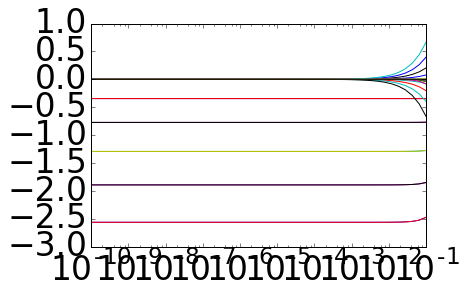

In [104]:
# Test the correct limit behavior of get_π̃τ̃_y1
nmax = 5
nelem =  nmax * nmax + 2*nmax
thetas = np.logspace(-10,-1)
pis = np.empty((len(thetas),nelem))
taus = np.empty((len(thetas),nelem))
for i in range(len(thetas)):
    pis[i], taus[i] = get_π̃τ̃_y1(thetas[i],nmax)
plt.plot(thetas, pis)
plt.xscale('log')

In [ ]:
m = 2
n = 6
mu = 2
nu = 8
r = 2.0
th = 0.5
fi = 0.2
print(B̃(m ,n ,mu,nu,r,th,fi,False,3))
print(B̃(m ,n ,mu,nu,r,π-th,π+fi,False,3))
print(B̃(mu,nu,m ,n ,r,π-th,π+fi,False,3))

In [ ]:
# Test of Mie reflection coefficients

startω =2.0*eV/ℏ
stopω = 5*eV/ℏ
ωlist = np.linspace(startω, stopω, 1000)

R = 7e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
nmax = 10


from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

ε_mlist = ε_drude(ε_inf, ω_p, γ_p, ωlist)
f, ax = plt.subplots()
ax.plot(ωlist/(eV/ℏ), (np.real(ε_mlist)), 'r-', 
         label="$\Re{} \epsilon_m$")
ax.plot(ωlist/(eV/ℏ), (np.imag(ε_mlist)), 'g-',
         label="$\Im{} \epsilon_m$")
ax.set_xlabel("$\omega$ / eV")
ax.legend(loc=4)
pp.savefig()

RVlist = np.empty((nmax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((nmax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = mie_coefficients(a=a, nmax=nmax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

ε_mlist = ε_drude(ε_inf, ω_p, γ_p, ωlist)

for n in range(nmax+1):
    f, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(ωlist/(eV/ℏ), (np.real(RVlist[n])), 'r-', 
             label="$\Re{} RV_"+str(n)+"$")
    ax[0].plot(ωlist/(eV/ℏ), (np.imag(RVlist[n])), 'g-',
             label="$\Im{} RV_"+str(n)+"$")
    ax[1].plot(ωlist/(eV/ℏ), (np.real(RHlist[n])), 'r-', 
             label="$\Re{} RH_"+str(n)+"$")
    ax[1].plot(ωlist/(eV/ℏ), (np.imag(RHlist[n])), 'g-',
             label="$\Im{} RH_"+str(n)+"$")

    ax[0].set_xlabel("$\omega$ / eV")
    ax[1].set_xlabel("$\omega$ / eV")
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    pp.savefig()

pp.close()

## Radial dependence of spherical dipole wave

In [ ]:
def h1(z):
    onent = 1j*z
    return 1j*np.exp(onent)*(-1/onent+1/(onent*onent))
    


xlist = np.linspace(.01,10,dtype=float)
zlist = np.empty((len(xlist),),dtype=np.complex_)
for i in range(len(xlist)):
    zlist[i] = zJn(1,xlist[i],J=3)[0][1]
plt.plot(xlist, (zlist-h1(xlist)).real, 'r-', xlist, (zlist-h1(xlist)).imag, 
        )


def g1(z):
    onent=1j*z
    return -1j*np.exp(onent)*(1/1/onent+1/(onent*onent))

    

In [ ]:
    source_cart=np.array([1e-5,1e-5,1e-5])
    dest_cart=np.array([1.,0,0])
    nmax=1
    J_ext=1
    J_scat=3
    my, ny = get_mn_y(nmax)
    nelem = len(my)
    #source to origin
    source_sph = cart2sph(source_cart)
    source_sph[0] = k * source_sph[0] 
    dest_sph = cart2sph(dest_cart)
    dest_sph[0] = k * dest_sph[0]
    if(dest_sph[0].real > source_sph[0].real):
        lo_sph = source_sph
        hi_sph = dest_sph
    else:
        lo_sph = dest_sph
        hi_sph = source_sph
    #lo_sph = source_sph
    #hi_sph = dest_sph
        
    M̃lo_y, Ñlo_y = vswf_yr1(lo_sph,nmax,J=J_ext)
    lo_loccart_basis = sph_loccart_basis(lo_sph, sphaxis=-1, cartaxis=None)
    M̃lo_cart_y = np.sum(M̃lo_y[:,:,ň]*lo_loccart_basis[ň,:,:],axis=-2)
    Ñlo_cart_y = np.sum(Ñlo_y[:,:,ň]*lo_loccart_basis[ň,:,:],axis=-2)
    
    M̃hi_y, Ñhi_y = vswf_yr1(hi_sph,nmax,J=J_scat)#J_scat
    hi_loccart_basis = sph_loccart_basis(hi_sph, sphaxis=-1, cartaxis=None)
    M̃hi_cart_y = np.sum(M̃hi_y[:,:,ň]*hi_loccart_basis[ň,:,:],axis=-2)
    Ñhi_cart_y = np.sum(Ñhi_y[:,:,ň]*hi_loccart_basis[ň,:,:],axis=-2)
    #print(Ñlo_cart_y.conj())
    #G_y = (M̃lo_cart_y[:,:,ň].conj() * M̃hi_cart_y[:,ň,:]#.conj() 
    Ñlo_cart_y.conj()  

In [ ]:
    pfz = 0.32573500793527994772 # 1./math.sqrt(3.*π)
    pf = 0.23032943298089031951 # 1./math.sqrt(6.*π)
    np.array([[pf,-1j*pf,0.],[0.,0.,pfz],[-pf,-1j*pf,0.]]).conj()- Ñlo_cart_y.conj()  

## Green's functions

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib



nmax = 1
J_ext = 1
J_scat = 3

k = 1
r_source=np.array([0,0,0])

E_0 = np.array([0,0,1.])

R=2 # zde jen kvůli šířce
h2 = 3*R
w2 = 3*R
z = np.linspace(-h2,h2,60)
x = np.linspace(-w2,w2,60)
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(x,z)
y = x*0.0

# Souřadnice a původní vlna
my, ny = get_mn_y(nmax)
nelem = len(my)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
rmrs = (cartgrid-r_source[ň,:])
expikr=np.exp(1j*k*sphgrid[:,0])[:,ň]
rnorm = np.linalg.norm(rmrs, axis=-1)

rnxrn = rmrs[...,:,ň] * rmrs[...,ň,:]
Ganal = G0_analytical(rmrs,k)
GanalT = G0T_analytical(rmrs,k)
GanalL = G0L_analytical(rmrs,k)
Nm1 = np.zeros((len(x),3),dtype=np.complex_)
Np1 = np.zeros((len(x),3),dtype=np.complex_)
N0 = np.zeros((len(x),3),dtype=np.complex_)
Gsum = np.zeros((len(x),3,3),dtype=np.complex_)
Gsum_slow = np.zeros((len(x),3,3),dtype=np.complex_)
for ri in range(len(x)):
    #print(cartgrid[ri], r_source)
    M_,N_ = vswf_yr1(sphgrid[ri],nmax,J=3)
    Nm1[ri] = N_[0]
    Np1[ri] = N_[2]
    N0[ri]  = N_[1]
    Gsum[ri] = G0_sum_1( np.array([0.00001,0,0]),cartgrid[ri], k, 1)
#    Gsum_slow[ri] = G0_sum_1_slow(cartgrid[ri], r_source, k, nmax)

N0 = sph_loccart2cart(N0, sphgrid, axis=-1)
Np1 = sph_loccart2cart(Np1, sphgrid, axis=-1)
Nm1 = sph_loccart2cart(Nm1, sphgrid, axis=-1)
    

#for ri in range(len(x)):
#    if (sphgrid[ri,0] < R):
#        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_in,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=1)
#        M_sph_ry_in[ri] = M
#        N_sph_ry_in[ri] = N
#    else:
#        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_scat)
#        M_sph_ry_scat[ri] = M
#        N_sph_ry_scat[ri] = N
#        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_ext)
#        M_sph_ry_ext[ri] = M
#        N_sph_ry_ext[ri] = N

_, cn = vswf_yr1(np.array([0.000001,0,0]),nmax,J=1)

Eanal = np.sum(E_0*Ganal, axis=-1)
EanalT = np.sum(E_0*GanalT, axis=-1)
EanalL = np.sum(E_0*GanalL, axis=-1)
Esum = np.sum(E_0*Gsum, axis=-1)
#Esum_slow = np.sum(E_0*Gsum_slow, axis=-1)


from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')


#page = 2
plthr = 1e-10
plthr_hi = 1
print(Eanal.shape, N0.shape, Nm1.shape, Np1.shape)
Ep = [Eanal, Esum, Eanal+Esum, Eanal/Esum]#, N0, Eanal/expikr, Esum/expikr, N0/expikr,Esum/Eanal/expikr**2]#Eanal/N0.conj(), Esum/N0, np.absolute(Esum)/np.absolute(Eanal), EanalT, EanalL, Nm1, Np1]
for page in range(len(Ep)):
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    print(cartgrid)
    print(plotfield)
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(20,20))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=220,
                       edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=220,
                       edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()

## Lattices

In [ ]:
# A lattice; TODO: drawing, extinction, ...
xN = 15
yN = 15
xd = 1e-7 # x spacing
yd = 1e-7 # y spacing
ω = 3.7*eV/ℏ
k = ω/c
N = yN*xN # No. of spheres
rad = np.full([N],7e-11) # sphere radii
ε_m = np.full([N],#-3+0.3j,
                  1.9, dtype=np.complex_) # particle permittivity
ε_b = 1 # background permittivity
k_out = math.sqrt(ε_b)*k
k_in = np.sqrt(ε_m)*k

#betap = π/2
k_cart = k_out * np.array([1,0,0])/math.sqrt(1)
E⃗_0 = np.array([0,1,0])#np.cross(k_cart,np.array([math.cos(betap),0,math.sin(betap)]))
#E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]

nmax = 1
J_scat=3
J_ext=1
x, y = np.meshgrid(np.arange(xN)*xd,np.arange(yN)*yd)
x = x.flatten()
y = y.flatten()
z = 0*x
cart_lattice=np.stack((x,y,z), axis=-1)

my, ny = get_mn_y(nmax)
nelem = len(my)

# Translation coefficient matrix T
transmat = np.zeros((N,2,nelem,N,2,nelem),dtype=np.complex_)
print(N*N*nelem*nelem, "iterations in creating the translation matrix; gonna take about",
      N*N*nelem*nelem*3e-4,"s")
import sys
sys.stdout.flush()
for l in range(N): # Translation from l to j
        for yl in range(nelem):
            for j in range(N):
              if (j != l):
                for yj in range(nelem):
                    d_l2j = cart2sph(cart_lattice[j] - cart_lattice[l]) # dementní uspořádání
                    A = Ã(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                    B = B̃(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                    transmat[j,0,yj,l,0,yl] = A
                    transmat[j,0,yj,l,1,yl] = B
                    transmat[j,1,yj,l,0,yl] = B 
                    transmat[j,1,yj,l,1,yl] = A
                    
# Vector M of individual particles' scattering matrices; for spheres, they are diagonal
scatmat = np.zeros((N,2,nelem,2,nelem), dtype=np.complex_)
for j in range(N):
    RH, RV, TH, TV = mie_coefficients(rad[j], nmax, 
                                  k_i=k_in[j], k_e=k_out,
                                  J_ext=J_ext, J_scat=J_scat)
    scatmat[j,0,:,0,:] = np.diag(RV[ny]) # N-waves; a/p
    scatmat[j,1,:,1,:] = np.diag(RH[ny]) # M-waves; b/q

# The initial field (here plane wave) decomposition coefficients p_0, q_0 with respect
# to each particle
pq_0 = np.empty((N,2,nelem), dtype=np.complex_)
p_y0, q_y0 = plane_pq_y(nmax, k_cart, E⃗_0)
#for j in range(N):
#    pq_0[j,0,:] = p_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))
#    pq_0[j,1,:] = q_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))
pq_0[:,0,:] = np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
pq_0[:,1,:] = np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * q_y0[ň, :]

# Now we solve a linear problem (1 - M T) A = M P_0
MT = np.empty((N,2,nelem,N,2,nelem),dtype=np.complex_)
MP_0 = np.empty((N,2,nelem),dtype=np.complex_)
for j in range(N): # I wonder how this can be done without this loop...
    MT[j] = np.tensordot(scatmat[j],transmat[j],axes=([-2,-1],[0,1]))
    MP_0[j] = np.tensordot(scatmat[j],pq_0[j],axes=([-2,-1],[-2,-1]))
leftmatrix = np.reshape(np.identity(N*2*nelem),(N,2,nelem,N,2,nelem)) - MT

ab = np.linalg.tensorsolve(leftmatrix, MP_0)
#np.angle(ab)
abs(ab)

In [ ]:
# Antti's results; using the translation symmetry to build the scattering matrix
import sys

xN = 35
yN = 35
xd = 3.6e-7 # x spacing
yd = 2e-7 # y spacing
ω = 3.469e15 #3.7*eV/ℏ
k = ω/c
N = yN*xN # No. of spheres
rad = np.full([N],3e-8) # sphere radii
ε_m = np.full([N],#-3+0.3j,
                  -14.88+0.43j, dtype=np.complex_) # particle permittivity
ε_b = 2.3104 # background permittivity
k_out = math.sqrt(ε_b)*k
k_in = np.sqrt(ε_m)*k

#betap = π/2
k_cart = k_out * np.array([1,0,0])/math.sqrt(1)
E⃗_0 = np.array([0,1,0])#np.cross(k_cart,np.array([math.cos(betap),0,math.sin(betap)]))
#E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]

nmax = 1
J_scat=3
J_ext=1
x, y = np.meshgrid(np.arange(xN)*xd,np.arange(yN)*yd)
xf = x.flatten()
yf = y.flatten()
zf = 0*xf
cart_lattice=np.stack((xf,yf,zf), axis=-1)

my, ny = get_mn_y(nmax)
nelem = len(my)

# Lattice speedup
Agrid = np.zeros((nelem, 2*xN, 2*yN, nelem),dtype=np.complex_)
Bgrid = np.zeros((nelem, 2*xN, 2*yN, nelem),dtype=np.complex_)
print(Agrid.shape)
sys.stdout.flush()
for yl in range(nelem):
    for xi in range(2*xN):
        for yi in range(2*yN):
            for yj in range(nelem):
              if((yi != yN) or (xi != xN)):
                d_l2j = cart2sph(np.array([(xi-xN)*xd, (yi-yN)*yd, 0]))
                Agrid[yl, xi, yi, yj] = Ã(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                Bgrid[yl, xi, yi, yj] = B̃(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
        
# Translation coefficient matrix T
transmat = np.zeros((xN, yN, 2, nelem, xN, yN, 2, nelem),dtype=np.complex_)
print(N*N*nelem*nelem, "iterations in creating da translatino matrix; gonna take about",
      N*N*nelem*nelem*3e-4,"s(?)")
sys.stdout.flush()
for xil in range(xN):
    for yil in range(yN):
        for xij in range(xN):
            for yij in range(yN):
              if ((xil != xij) or (yil != yij)):
                    transmat[xij, yij,0, :,xil,yil,0,:] = Agrid[:, xil - xij + xN, yil - yij + yN, :]
                    transmat[xij, yij,0, :,xil,yil,1,:] = Bgrid[:, xil - xij + xN, yil - yij + yN, :]
                    transmat[xij, yij,1, :,xil,yil,0,:] = Bgrid[:, xil - xij + xN, yil - yij + yN, :]
                    transmat[xij, yij,1, :,xil,yil,1,:] = Agrid[:, xil - xij + xN, yil - yij + yN, :]


transmat.shape = (xN*yN,2,nelem,xN*yN,2,nelem)
print("so how much did it take?")
sys.stdout.flush()

print("Calculating Mie coefficients")
sys.stdout.flush()
# Vector M of individual particles' scattering matrices; for spheres, they are diagonal
scatmat = np.zeros((N,2,nelem,2,nelem), dtype=np.complex_)
for j in range(N):
    RH, RV, TH, TV = mie_coefficients(rad[j], nmax, 
                                  k_i=k_in[j], k_e=k_out,
                                  J_ext=J_ext, J_scat=J_scat)
    scatmat[j,0,:,0,:] = np.diag(RV[ny]) # N-waves; a/p
    scatmat[j,1,:,1,:] = np.diag(RH[ny]) # M-waves; b/q

print("Setting initial field")
sys.stdout.flush()
# The initial field (here plane wave) decomposition coefficients p_0, q_0 with respect
# to each particle
pq_0 = np.zeros((N,2,nelem), dtype=np.complex_)
p_y0, q_y0 = plane_pq_y(nmax, k_cart, E⃗_0)
#for j in range(N):
#    pq_0[j,0,:] = p_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))
#    pq_0[j,1,:] = q_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))

pq_0[:,0,0] = 1#np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
pq_0[:,0,2] = -1#np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
#pq_0[:,1,:] = 0#np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * q_y0[ň, :]

print("Initializing the matrix problem")
sys.stdout.flush()
# Now we solve a linear problem (1 - M T) A = M P_0
MT = np.empty((N,2,nelem,N,2,nelem),dtype=np.complex_)
MP_0 = np.empty((N,2,nelem),dtype=np.complex_)
for j in range(N): # I wonder how this can be done without this loop...
    MT[j] = np.tensordot(scatmat[j],transmat[j],axes=([-2,-1],[0,1]))
    MP_0[j] = np.tensordot(scatmat[j],pq_0[j],axes=([-2,-1],[-2,-1]))
leftmatrix = np.reshape(np.identity(N*2*nelem),(N,2,nelem,N,2,nelem)) - MT

print("solving")
sys.stdout.flush()
ab = np.linalg.tensorsolve(leftmatrix, MP_0)
print("Done.")
#np.angle(ab)

In [ ]:
xx = 20
yy = 20
transmat.shape = (xN,yN,2,nelem,xN,yN,2,nelem)

%matplotlib inline
from matplotlib import pyplot as plt
#xf.shape
#f, ax = plt.subplots()
C = np.real(transmat[xx,yy,0,0,:,:,0,0])
#C = ab[:,1,1].
#C.shape=x.shape
plt.pcolormesh(x,y,C,cmap='jet'
             )
plt.colorbar()
C

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
#xf.shape
#f, ax = plt.subplots()
C = np.angle((ab[:,0,0]+ab[:,0,2]
     ))
#C = ab[:,1,1].
C.shape=x.shape
plt.pcolormesh(x,y,C,cmap='jet'
             )
plt.colorbar()
C